In [1]:
import os
# have to set the R path before I can use notebook_functions
R_PATH = "/home/jdkent/envs/aim1_valid/lib/R"
os.environ['R_HOME'] = R_PATH

# number of threads you wish to parallelize across
N_THREADS = 32

# paths to the results
LSS_SCH_PATH = '../lss-schaeferparcel-400/nibetaseries'
LSA_SCH_PATH = '../lsa-schaeferparcel-400/nibetaseries'

LSS_ACT_PATH = '../lss-overallresponse/nibetaseries'
LSA_ACT_PATH = '../lsa-overallresponse/nibetaseries'

# ppi results
PPI_ACT_PATH = './ppiMatrices'
PPI_SCH_PATH = './ppiMatricesSchaefer'
# path to bold QA measures
BOLD_QA = '../mriqc/group_bold.tsv'

# path to participants file
PARTICIPANT_DEMO = '../../participants.tsv'

# absolute max the z-value can be for fisher's r->z transform
THRESH = 2.647

# activation atlas
ACT_ATLAS = '../data/overall_response_atlas.nii.gz'


In [2]:
import re
from subprocess import call

import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing.pool import Pool
from bids.layout import BIDSLayout
from sklearn.metrics import confusion_matrix
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_chisquare, binom_test, proportion_confint
import nibabel as nib
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from scipy.stats import ttest_1samp
from statsmodels.stats.proportion import binom_test

import notebook_functions as nf

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally

In [3]:
import importlib
importlib.reload(nf)

<module 'notebook_functions' from '/home/jdkent/hpchome/bids/derivatives/PPITest/notebook_functions.py'>

In [4]:
def save_eps(fig, fname):
    fig.savefig(fname + '.pdf', bbox_inches='tight')
    call(["pdf2ps", fname + '.pdf', fname + '.eps'])
    os.remove(fname + '.pdf')

In [5]:
# pulled from here: https://github.com/psinger/CorrelationStats/blob/c608d8376d765246cd2f0d6b0192507a16bd0901/corrstats.py#L21-L68
import numpy as np
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh

def rz_ci(r, n, conf_level = 0.95):
    zr_se = pow(1/(n - 3), .5)
    moe = norm.ppf(1 - (1 - conf_level)/float(2)) * zr_se
    zu = atanh(r) + moe
    zl = atanh(r) - moe
    return tanh((zl, zu))

def rho_rxy_rxz(rxy, rxz, ryz):
    num = (ryz-1/2.*rxy*rxz)*(1-pow(rxy,2)-pow(rxz,2)-pow(ryz,2))+pow(ryz,3)
    den = (1 - pow(rxy,2)) * (1 - pow(rxz,2))
    return num/float(den)

def dependent_corr(xy, xz, yz, n, twotailed=True, conf_level=0.95, method='steiger'):
    """
    Calculates the statistic significance between two dependent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between x and z
    @param yz: correlation coefficient between y and z
    @param n: number of elements in x, y and z
    @param twotailed: whether to calculate a one or two tailed test, only works for 'steiger' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'steiger' or 'zou'
    @return: t and p-val
    """
    if method == 'steiger':
        d = xy - xz
        determin = 1 - xy * xy - xz * xz - yz * yz + 2 * xy * xz * yz
        av = (xy + xz)/2
        cube = (1 - yz) * (1 - yz) * (1 - yz)

        t2 = d * np.sqrt((n - 1) * (1 + yz)/(((2 * (n - 1)/(n - 3)) * determin + av * av * cube)))
        p = 1 - t.cdf(abs(t2), n - 3)

        if twotailed:
            p *= 2

        return t2, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(xz, n, conf_level=conf_level)[0]
        U2 = rz_ci(xz, n, conf_level=conf_level)[1]
        rho_r12_r13 = rho_rxy_rxz(xy, xz, yz)
        lower = xy - xz - pow((pow((xy - L1), 2) + pow((U2 - xz), 2) - 2 * rho_r12_r13 * (xy - L1) * (U2 - xz)), 0.5)
        upper = xy - xz + pow((pow((U1 - xy), 2) + pow((xz - L2), 2) - 2 * rho_r12_r13 * (U1 - xy) * (xz - L2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

## load the bold qa measures

In [6]:
def proc_bold_qa(bold_qa_file):
    bold_qa = pd.read_csv(bold_qa_file, sep='\t')
    # drop the rest rows
    bold_qa = bold_qa[~bold_qa['bids_name'].str.contains('.*rest.*')]
    
    split_columns = bold_qa['bids_name'].str.split('_|-', n = 7, expand = True)
    bold_qa['task'] = split_columns[5]
    bold_qa['participant_id'] = split_columns[1]
    return bold_qa

bold_qa = proc_bold_qa(BOLD_QA)
bold_qa.head()

bids_name       aor       aqi  dummy_trs  \
0    sub-GE120001_ses-pre_task-fauxbold_bold  0.001063  0.006351          2   
3  sub-GE120001_ses-pre_task-taskswitch_bold  0.003942  0.005572          2   
4    sub-GE120002_ses-pre_task-fauxbold_bold  0.002056  0.010868          1   
7  sub-GE120002_ses-pre_task-taskswitch_bold  0.002134  0.004827          1   
8    sub-GE120003_ses-pre_task-fauxbold_bold  0.003094  0.018135          1   

   dvars_nstd  dvars_std  dvars_vstd       efc        fber   fd_mean  ...  \
0   16.187316   1.198663    1.010760  0.448331  3009467.75  0.103818  ...   
3   15.734272   1.148948    0.957532  0.450887  1364181.25  0.138379  ...   
4   17.975215   1.024274    1.143355  0.432753  3026978.75  0.227028  ...   
7   16.918552   1.176876    0.990735  0.431836  4213331.00  0.169619  ...   
8   38.223070   1.116687    0.909317  0.393451  2381240.50  0.577373  ...   

   summary_fg_mad  summary_fg_mean  summary_fg_median  summary_fg_n  \
0      232.520432      1381.902222        1410.488159       29195.0   
3      216.930939      1391.725708        1421.432861       29084.0   
4      225.343140      1283.572998        1322.169800       27338.0   
7      229.552505      1292.104004        1334.634033       27340.0   
8      246.342178      1247.227295        1309.490601       23125.0   

   summary_fg_p05  summary_fg_p95  summary_fg_stdv       tsnr        task  \
0      837.753119     1812.366785       297.530945  64.075073    fauxbold   
3      868.629898     1788.999225       284.924835  72.902779  taskswitch   
4      738.498715     1686.504254       287.157501  47.578674    fauxbold   
7      734.595834     1700.930396       292.718201  71.898445  taskswitch   
8      595.968738     1648.415723       314.057434  31.255548    fauxbold   

   participant_id  
0        GE120001  
3        GE120001  
4        GE120002  
7        GE120002  
8        GE120003  

[5 rows x 47 columns]

In [7]:
bold_qa_select = bold_qa[['participant_id', 'task', 'tsnr', 'fd_mean', 'fd_num']]

In [8]:
# eliminate people with fd_num >= 100 (threshold to keep number of regressors low)
bad_participants = bold_qa_select[bold_qa_select['fd_num'] >= 100]['participant_id'].unique()
bad_participants

array(['GE120003', 'GE120015', 'GE120020', 'GE120021', 'GE120024',
       'GE120026', 'GE120037', 'GE120038', 'GE120039', 'GE120043',
       'GE120045', 'GE120049', 'GE120052', 'GE120054', 'GE120055',
       'GE120059', 'GE120060', 'GE120065', 'GE120068', 'GE120069',
       'GE120075'], dtype=object)

In [9]:
# drop the num measurement
bold_qa_select.drop(columns='fd_num', inplace=True)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Get the correlation files

In [10]:
lss_sch_layout = BIDSLayout(LSS_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lsa_sch_layout = BIDSLayout(LSA_SCH_PATH, validate=False, config=['bids', 'derivatives'])
ppi_sch_layout = BIDSLayout(PPI_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lss_act_layout = BIDSLayout(LSS_ACT_PATH, validate=False, config=['bids', 'derivatives'])
lsa_act_layout = BIDSLayout(LSA_ACT_PATH, validate=False, config=['bids', 'derivatives'])
ppi_act_layout = BIDSLayout(PPI_ACT_PATH, validate=False, config=['bids', 'derivatives'])

In [11]:
ent = lss_sch_layout.entities['subject']
good_participants = list(set(ent.unique()) - set(bad_participants))
len(good_participants)

40

In [12]:
# activation atlas
ts_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_act_ppi_objs = nf.get_layout_objects(ppi_act_layout,
                                       ['dualxsingle', 'dualxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="taskswitch",
                                       subject=good_participants)

fb_act_ppi_objs = nf.get_layout_objects(ppi_act_layout,
                                       ['dualxsingle', 'dualxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="fauxbold",
                                       subject=good_participants)


# schaefer atlas
ts_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_sch_ppi_objs = nf.get_layout_objects(ppi_sch_layout,
                                       ['dualxsingle', 'dualxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="taskswitch",
                                       subject=good_participants)

fb_sch_ppi_objs = nf.get_layout_objects(ppi_sch_layout,
                                       ['dualxsingle', 'dualxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="fauxbold",
                                       subject=good_participants)

In [13]:
# ppi activation
ts_act_ppi_switchxrepeat = nf.bind_matrices(ts_act_ppi_objs['switchxrepeat'], "ppi")
fb_act_ppi_switchxrepeat = nf.bind_matrices(fb_act_ppi_objs['switchxrepeat'], "ppi")
ts_act_ppi_dualxsingle = nf.bind_matrices(ts_act_ppi_objs['dualxsingle'], "ppi")
fb_act_ppi_dualxsingle = nf.bind_matrices(fb_act_ppi_objs['dualxsingle'], "ppi")
ts_act_ppi_repeatxsingle = nf.bind_matrices(ts_act_ppi_objs['repeatxsingle'], "ppi")
fb_act_ppi_repeatxsingle = nf.bind_matrices(fb_act_ppi_objs['repeatxsingle'], "ppi")

# ppi schaefer
ts_sch_ppi_switchxrepeat = nf.bind_matrices(ts_sch_ppi_objs['switchxrepeat'], "ppi")
fb_sch_ppi_switchxrepeat = nf.bind_matrices(fb_sch_ppi_objs['switchxrepeat'], "ppi")
ts_sch_ppi_dualxsingle = nf.bind_matrices(ts_sch_ppi_objs['dualxsingle'], "ppi")
fb_sch_ppi_dualxsingle = nf.bind_matrices(fb_sch_ppi_objs['dualxsingle'], "ppi")
ts_sch_ppi_repeatxsingle = nf.bind_matrices(ts_sch_ppi_objs['repeatxsingle'], "ppi")
fb_sch_ppi_repeatxsingle = nf.bind_matrices(fb_sch_ppi_objs['repeatxsingle'], "ppi")


# lss activation
ts_act_lss_switchxrepeat = nf.bind_matrices(ts_act_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_act_lss_objs['repeat'], "repeat").iloc[:,:-2]
ts_act_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]
fb_act_lss_switchxrepeat = nf.bind_matrices(fb_act_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lss_objs['repeat'], "repeat").iloc[:,:-2]
fb_act_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]

ts_act_lss_dualxsingle = nf.bind_matrices(ts_act_lss_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(ts_act_lss_objs['single'], "single").iloc[:,:-2]
ts_act_lss_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]
fb_act_lss_dualxsingle = nf.bind_matrices(fb_act_lss_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(fb_act_lss_objs['single'], "single").iloc[:,:-2]
fb_act_lss_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]

ts_act_lss_repeatxsingle = nf.bind_matrices(ts_act_lss_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_act_lss_objs['single'], "single").iloc[:,:-2]
ts_act_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]
fb_act_lss_repeatxsingle = nf.bind_matrices(fb_act_lss_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lss_objs['single'], "single").iloc[:,:-2]
fb_act_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]

# lss schaefer
ts_sch_lss_switchxrepeat = nf.bind_matrices(ts_sch_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_sch_lss_objs['repeat'], "repeat").iloc[:,:-2]
ts_sch_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]
fb_sch_lss_switchxrepeat = nf.bind_matrices(fb_sch_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lss_objs['repeat'], "repeat").iloc[:,:-2]
fb_sch_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]

ts_sch_lss_dualxsingle = nf.bind_matrices(ts_sch_lss_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(ts_sch_lss_objs['single'], "single").iloc[:,:-2]
ts_sch_lss_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]
fb_sch_lss_dualxsingle = nf.bind_matrices(fb_sch_lss_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(fb_sch_lss_objs['single'], "single").iloc[:,:-2]
fb_sch_lss_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]

ts_sch_lss_repeatxsingle = nf.bind_matrices(ts_sch_lss_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_sch_lss_objs['single'], "single").iloc[:,:-2]
ts_sch_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]
fb_sch_lss_repeatxsingle = nf.bind_matrices(fb_sch_lss_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lss_objs['single'], "single").iloc[:,:-2]
fb_sch_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]

# lsa activation
ts_act_lsa_switchxrepeat = nf.bind_matrices(ts_act_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_act_lsa_objs['repeat'], "repeat").iloc[:,:-2]
ts_act_lsa_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]
fb_act_lsa_switchxrepeat = nf.bind_matrices(fb_act_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lsa_objs['repeat'], "repeat").iloc[:,:-2]
fb_act_lsa_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]

ts_act_lsa_dualxsingle = nf.bind_matrices(ts_act_lsa_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(ts_act_lsa_objs['single'], "single").iloc[:,:-2]
ts_act_lsa_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]
fb_act_lsa_dualxsingle = nf.bind_matrices(fb_act_lsa_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(fb_act_lsa_objs['single'], "single").iloc[:,:-2]
fb_act_lsa_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]

ts_act_lsa_repeatxsingle = nf.bind_matrices(ts_act_lsa_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_act_lsa_objs['single'], "single").iloc[:,:-2]
ts_act_lsa_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]
fb_act_lsa_repeatxsingle = nf.bind_matrices(fb_act_lsa_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lsa_objs['single'], "single").iloc[:,:-2]
fb_act_lsa_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]

# lsa schaefer
ts_sch_lsa_switchxrepeat = nf.bind_matrices(ts_sch_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_sch_lsa_objs['repeat'], "repeat").iloc[:,:-2]
ts_sch_lsa_switchxrepeat[['participant_id', 'task']] = ts_sch_ppi_switchxrepeat[['participant_id', 'task']]
fb_sch_lsa_switchxrepeat = nf.bind_matrices(fb_sch_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lsa_objs['repeat'], "repeat").iloc[:,:-2]
fb_sch_lsa_switchxrepeat[['participant_id', 'task']] = ts_sch_ppi_switchxrepeat[['participant_id', 'task']]

ts_sch_lsa_dualxsingle = nf.bind_matrices(ts_sch_lsa_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(ts_sch_lsa_objs['single'], "single").iloc[:,:-2]
ts_sch_lsa_dualxsingle[['participant_id', 'task']] = ts_sch_ppi_dualxsingle[['participant_id', 'task']]
fb_sch_lsa_dualxsingle = nf.bind_matrices(fb_sch_lsa_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(fb_sch_lsa_objs['single'], "single").iloc[:,:-2]
fb_sch_lsa_dualxsingle[['participant_id', 'task']] = ts_sch_ppi_dualxsingle[['participant_id', 'task']]

ts_sch_lsa_repeatxsingle = nf.bind_matrices(ts_sch_lsa_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_sch_lsa_objs['single'], "single").iloc[:,:-2]
ts_sch_lsa_repeatxsingle[['participant_id', 'task']] = ts_sch_ppi_repeatxsingle[['participant_id', 'task']]
fb_sch_lsa_repeatxsingle = nf.bind_matrices(fb_sch_lsa_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lsa_objs['single'], "single").iloc[:,:-2]
fb_sch_lsa_repeatxsingle[['participant_id', 'task']] = ts_sch_ppi_repeatxsingle[['participant_id', 'task']]

In [14]:
len(fb_sch_ppi_switchxrepeat)

40

In [15]:
np.corrcoef(ts_sch_ppi_repeatxsingle.mean(axis=0).values, ts_sch_lss_repeatxsingle.mean(axis=0).values)

array([[1.        , 0.61467669],
       [0.61467669, 1.        ]])

In [16]:
ts_act_lsa_repeatxsingle_mean = ts_act_lsa_repeatxsingle.mean(axis=0).values
ts_act_lss_repeatxsingle_mean = ts_act_lss_repeatxsingle.mean(axis=0).values
ts_act_ppi_repeatxsingle_mean = ts_act_ppi_repeatxsingle.mean(axis=0).values
np.corrcoef([ts_act_lsa_repeatxsingle_mean, ts_act_lss_repeatxsingle_mean, ts_act_ppi_repeatxsingle_mean])

array([[1.        , 0.28734264, 0.19827265],
       [0.28734264, 1.        , 0.56697634],
       [0.19827265, 0.56697634, 1.        ]])

In [17]:
ts_act_lsa_switchxrepeat_mean = ts_act_lsa_switchxrepeat.mean(axis=0).values
ts_act_lss_switchxrepeat_mean = ts_act_lss_switchxrepeat.mean(axis=0).values
ts_act_ppi_switchxrepeat_mean = ts_act_ppi_switchxrepeat.mean(axis=0).values
np.corrcoef([ts_act_lsa_switchxrepeat_mean, ts_act_lss_switchxrepeat_mean, ts_act_ppi_switchxrepeat_mean])

array([[1.        , 0.30559026, 0.23456179],
       [0.30559026, 1.        , 0.45726016],
       [0.23456179, 0.45726016, 1.        ]])

In [18]:
ts_act_lsa_dualxsingle_mean = ts_act_lsa_dualxsingle.mean(axis=0).values
ts_act_lss_dualxsingle_mean = ts_act_lss_dualxsingle.mean(axis=0).values
ts_act_ppi_dualxsingle_mean = ts_act_ppi_dualxsingle.mean(axis=0).values
np.corrcoef([ts_act_lsa_dualxsingle_mean, ts_act_lss_dualxsingle_mean, ts_act_ppi_dualxsingle_mean])

array([[1.        , 0.30498854, 0.20166615],
       [0.30498854, 1.        , 0.59099154],
       [0.20166615, 0.59099154, 1.        ]])

## Prep for analysis

In [19]:
# collect permutations and number of significant values found for each condition
result_collector = {
    'atlas': [],
    'data': [],
    'contrast': [],
    'estimator': [],
    'participants': [],
    'observed_value': [],
    'binom_p_value': [],
    'corr_t': [],
    'corr_p': [],
    'pos_res': [],
    'neg_res': [],
}

correlation_collector = {
    "atlas": [],
    "data": [],
    "contrast": [],
    "participants": [],
    "lssxppi": [],
    "lsaxppi": [],
    "lsaxlss": [],
    "corr_t": [],
    "corr_p": [],
}

In [20]:
# load coordinate table for clusters:
# for making activation atlas glass brain images
coords_df = pd.read_csv('../firstLevelAnalysis/outputs/cluster_table.tsv', sep='\t')

In [21]:
def analyze_data(ppi_contrast, lss_contrast, lsa_contrast, data, result_collector, correlation_collector,
                 contrast, atlas, coords_df, best_regions=None, best_regions_orig=None, create_brain_fig=True):
    
    
    fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
        ppi_contrast, lss_contrast, lsa_contrast,
        rois=atlas, nthreads=N_THREADS, use_python=True)
    
    if atlas == "activation":
        lss_fig_brain = nf.make_glass_brain(overlap_lss_df, coords_df, cbar_ticks=["LSS", "PPI", "Both"],
                                            cmap_list=["#ff7f0e", "#2ca02c", "#da5bac",])
        lsa_fig_brain = nf.make_glass_brain(overlap_lsa_df, coords_df, cbar_ticks=["LSA", "PPI", "Both"],
                                            cmap_list=["#1f77b4", "#2ca02c", "#da5bac"])
        atlas_name = atlas.title()
        atlas_fname = atlas
    elif atlas == "schaefer" and best_regions:
        lss_fig_brain = nf.make_glass_brain(
            overlap_lss_df.loc[best_regions, best_regions],
            coords_df,
            annotate_nodes=False,
            color_nodes=True,
            cbar_ticks=["LSS", "PPI", "Both"],
            cmap_list=["#ff7f0e", "#2ca02c", "#da5bac"],
        )
        lsa_fig_brain = nf.make_glass_brain(
            overlap_lsa_df.loc[best_regions, best_regions],
            coords_df,
            annotate_nodes=False,
            color_nodes=True,
            cbar_ticks=["LSA", "PPI", "Both"],
            cmap_list=["#1f77b4", "#2ca02c", "#da5bac"],
        )
        atlas_name = (atlas + " (Top 20 {})").title().format("ROIs")
        atlas_fname = ''.join([atlas, "best"])
        # print out number of overlapping regions
        lss_overlap = (overlap_lss_df.loc[best_regions, best_regions].values == 3).sum() // 2
        lsa_overlap = (overlap_lsa_df.loc[best_regions, best_regions].values == 3).sum() // 2
        print("schaeferbest lss x ppi overlap: ", str(lss_overlap))
        print("schaeferbest lsa x ppi overlap: ", str(lsa_overlap))
    else:
        atlas_fname = altas
    
    if create_brain_fig:
        contrast_name = contrast.replace('x', ' - ').title()
        title_tmp = "{atlas} Atlas: {contrast} ({data} Data)"
        title = title_tmp.format(atlas=atlas_name, contrast=contrast_name, data=data.title())
        lss_fig_brain.suptitle(title, size=30, weight='heavy')
        eps_tmp = './outputs/data-{data}_type-brain_atlas-{atlas}_contrast-{contrast}_compare-{methods}'
        outfile_lss = eps_tmp.format(data=data, atlas=atlas_fname, contrast=contrast, methods="lssxppi")
        save_eps(lss_fig_brain, outfile_lss)
        
        lsa_fig_brain.suptitle(title, size=30, weight='heavy')
        outfile_lsa = eps_tmp.format(data=data, atlas=atlas_fname, contrast=contrast, methods="lsaxppi")
        save_eps(lsa_fig_brain, outfile_lsa)
    
    
    estimates_dict = {
        "ppi": None,
        "estimates": None,
        "estimators": None,
        "atlas": None,
        "data": None,
        "contrast": None,
    }


    if best_regions and best_regions_orig:
        bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)
        
        #
        ppi_sig_bool = ppi_model_df['p_value'][bool_query] < 0.05
        lss_sig_bool = lss_model_df['p_value'][bool_query] < 0.05
        lsa_sig_bool = lsa_model_df['p_value'][bool_query] < 0.05
        ppi_sig = np.sum(ppi_sig_bool)
        lss_sig = np.sum(lss_sig_bool)
        lsa_sig = np.sum(lsa_sig_bool)
        print("schaeferbest ppi sig: ", str(ppi_sig))
        print("schaeferbest lss sig: ", str(lss_sig))
        print("schaeferbest lsa sig: ", str(lsa_sig))
        ppi_len = len(ppi_model_df['p_value'][bool_query])
        lss_len = len(lss_model_df['p_value'][bool_query])
        lsa_len = len(lsa_model_df['p_value'][bool_query])
        
        # measure how many increases/decreases in connectivity there are
        ppi_pos_res = np.sum(ppi_model_df['estimate'][bool_query][ppi_sig_bool] > 0)
        ppi_neg_res = np.sum(ppi_model_df['estimate'][bool_query][ppi_sig_bool] < 0)
        
        lss_pos_res = np.sum(lss_model_df['estimate'][bool_query][lss_sig_bool] > 0)
        lss_neg_res = np.sum(lss_model_df['estimate'][bool_query][lss_sig_bool] < 0)

        lsa_pos_res = np.sum(lsa_model_df['estimate'][bool_query][lsa_sig_bool] > 0)
        lsa_neg_res = np.sum(lsa_model_df['estimate'][bool_query][lsa_sig_bool] < 0)

        corr_mat = np.corrcoef([lsa_model_df["estimate"][bool_query],
                                lss_model_df["estimate"][bool_query],
                                ppi_model_df["estimate"][bool_query]])
        lsa_lss_corr = corr_mat[1, 0]
        lsa_ppi_corr = corr_mat[2, 0]
        lss_ppi_corr = corr_mat[2, 1]
        
        print("Schaefer Top 20")
        print(corr_mat)

        corr_t, corr_p = dependent_corr(lss_ppi_corr, lsa_ppi_corr, lsa_lss_corr, len(lsa_model_df["estimate"][bool_query]))
        
        # start making the dataframe
        ppi_est_demean = ppi_model_df['estimate'][bool_query] - ppi_model_df['estimate'][bool_query].mean()
        lss_est_demean = lss_model_df['estimate'][bool_query] - lss_model_df['estimate'][bool_query].mean()
        lsa_est_demean = lsa_model_df['estimate'][bool_query] - lsa_model_df['estimate'][bool_query].mean()
        estimates_dict['ppi'] = pd.concat([ppi_est_demean, ppi_est_demean])
        estimates_dict['estimates'] = pd.concat([lss_est_demean, lsa_est_demean])
        estimates_dict['estimators'] = (["lss"] * len(lss_model_df['estimate'][bool_query])) + (["lsa"] * len(lsa_model_df['estimate'][bool_query]))
        estimates_dict['atlas'] = [atlas_fname] * len(estimates_dict['ppi'])
        estimates_dict['data'] = [data] * len(estimates_dict['ppi'])
        estimates_dict['contrast'] = [contrast] * len(estimates_dict['ppi'])
    else:
        ppi_sig_bool = ppi_model_df['p_value'] < 0.05
        lss_sig_bool = lss_model_df['p_value'] < 0.05
        lsa_sig_bool = lsa_model_df['p_value'] < 0.05
        ppi_sig = np.sum(ppi_sig_bool)
        lss_sig = np.sum(lss_sig_bool)
        lsa_sig = np.sum(lsa_sig_bool)
        ppi_len = len(ppi_model_df['p_value'])
        lss_len = len(lss_model_df['p_value'])
        lsa_len = len(lsa_model_df['p_value'])
        
        ppi_pos_res = np.sum(ppi_model_df['estimate'][ppi_sig_bool] > 0)
        ppi_neg_res = np.sum(ppi_model_df['estimate'][ppi_sig_bool] < 0)
        
        lss_pos_res = np.sum(lss_model_df['estimate'][lss_sig_bool] > 0)
        lss_neg_res = np.sum(lss_model_df['estimate'][lss_sig_bool] < 0)

        lsa_pos_res = np.sum(lsa_model_df['estimate'][lsa_sig_bool] > 0)
        lsa_neg_res = np.sum(lsa_model_df['estimate'][lsa_sig_bool] < 0)
        corr_mat = np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])
        lsa_lss_corr = corr_mat[1, 0]
        lsa_ppi_corr = corr_mat[2, 0]
        lss_ppi_corr = corr_mat[2, 1]

        print(corr_mat)

        corr_t, corr_p = dependent_corr(lss_ppi_corr, lsa_ppi_corr, lsa_lss_corr, len(lsa_model_df["estimate"]))
        
        ppi_est_demean = ppi_model_df['estimate'] - ppi_model_df['estimate'].mean()
        lss_est_demean = lss_model_df['estimate'] - lss_model_df['estimate'].mean()
        lsa_est_demean = lsa_model_df['estimate'] - lsa_model_df['estimate'].mean()
        estimates_dict['ppi'] = pd.concat([ppi_est_demean, ppi_est_demean])
        estimates_dict['estimates'] = pd.concat([lss_est_demean, lsa_est_demean])
        estimates_dict['estimators'] = (["lss"] * len(lss_model_df['estimate'])) + (["lsa"] * len(lsa_model_df['estimate']))
        estimates_dict['atlas'] = [atlas_fname] * len(estimates_dict['ppi'])
        estimates_dict['data'] = [data] * len(estimates_dict['ppi'])
        estimates_dict['contrast'] = [contrast] * len(estimates_dict['ppi'])
    
    # make temporary dataframe
    estimates_df = pd.DataFrame.from_dict(estimates_dict)
            
    correlation_collector['atlas'].append(atlas_fname)
    correlation_collector['data'].append(data)
    correlation_collector['contrast'].append(contrast)
    correlation_collector['participants'].append('filtered')
    correlation_collector["lssxppi"].append(lss_ppi_corr)
    correlation_collector["lsaxppi"].append(lsa_ppi_corr)
    correlation_collector["lsaxlss"].append(lsa_lss_corr)
    correlation_collector["corr_t"].append(corr_t)
    correlation_collector["corr_p"].append(corr_p)
    
    
    # PPI
    result_collector['atlas'].append(atlas_fname)
    result_collector['data'].append(data)
    result_collector['contrast'].append(contrast)
    result_collector['participants'].append('filtered')
    result_collector['estimator'].append('ppi')
    result_collector['observed_value'].append(ppi_sig)
    result_collector['binom_p_value'].append(binom_test(ppi_sig, ppi_len, prop=0.05, alternative='larger'))
    result_collector['corr_t'].append(corr_t)
    result_collector['corr_p'].append(corr_p)
    result_collector['pos_res'].append(ppi_pos_res)
    result_collector['neg_res'].append(ppi_neg_res)
    
    # LSS
    result_collector['atlas'].append(atlas_fname)
    result_collector['data'].append(data)
    result_collector['contrast'].append(contrast)
    result_collector['participants'].append('filtered')
    result_collector['estimator'].append('lss')
    result_collector['observed_value'].append(lss_sig)
    result_collector['binom_p_value'].append(binom_test(lss_sig, lss_len, prop=0.05, alternative='larger'))
    result_collector['corr_t'].append(corr_t)
    result_collector['corr_p'].append(corr_p)
    result_collector['pos_res'].append(lss_pos_res)
    result_collector['neg_res'].append(lss_neg_res)

    # LSA
    result_collector['atlas'].append(atlas_fname)
    result_collector['data'].append(data)
    result_collector['contrast'].append(contrast)
    result_collector['participants'].append('filtered')
    result_collector['estimator'].append('lsa')
    result_collector['observed_value'].append(lsa_sig)
    result_collector['binom_p_value'].append(binom_test(lsa_sig, lsa_len, prop=0.05, alternative='larger'))
    result_collector['corr_t'].append(corr_t)
    result_collector['corr_p'].append(corr_p)
    result_collector['pos_res'].append(lsa_pos_res)
    result_collector['neg_res'].append(lsa_neg_res)

    if atlas == "schaefer":
        schaefer_estimates_dict = {
            "ppi": None,
            "estimates": None,
            "estimators": None,
            "atlas": None,
            "data": None,
            "contrast": None,
        }

        ppi_sig_bool = ppi_model_df['p_value'] < 0.05
        lss_sig_bool = lss_model_df['p_value'] < 0.05
        lsa_sig_bool = lsa_model_df['p_value'] < 0.05
        ppi_sig = np.sum(ppi_sig_bool)
        lss_sig = np.sum(lss_sig_bool)
        lsa_sig = np.sum(lsa_sig_bool)
        ppi_len = len(ppi_model_df['p_value'])
        lss_len = len(lss_model_df['p_value'])
        lsa_len = len(lsa_model_df['p_value'])
        
        ppi_pos_res = np.sum(ppi_model_df['estimate'][ppi_sig_bool] > 0)
        ppi_neg_res = np.sum(ppi_model_df['estimate'][ppi_sig_bool] < 0)
        
        lss_pos_res = np.sum(lss_model_df['estimate'][lss_sig_bool] > 0)
        lss_neg_res = np.sum(lss_model_df['estimate'][lss_sig_bool] < 0)

        lsa_pos_res = np.sum(lsa_model_df['estimate'][lsa_sig_bool] > 0)
        lsa_neg_res = np.sum(lsa_model_df['estimate'][lsa_sig_bool] < 0)
        
        corr_mat = np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])
        lsa_lss_corr = corr_mat[1, 0]
        lsa_ppi_corr = corr_mat[2, 0]
        lss_ppi_corr = corr_mat[2, 1]
        
        print("Schaefer Full")
        print(corr_mat)

        corr_t, corr_p = dependent_corr(lss_ppi_corr, lsa_ppi_corr, lsa_lss_corr, len(lsa_model_df["estimate"]))
        
        ppi_est_demean = ppi_model_df['estimate'] - ppi_model_df['estimate'].mean()
        lss_est_demean = lss_model_df['estimate'] - lss_model_df['estimate'].mean()
        lsa_est_demean = lsa_model_df['estimate'] - lsa_model_df['estimate'].mean()
        schaefer_estimates_dict['ppi'] = pd.concat([ppi_est_demean, ppi_est_demean])
        schaefer_estimates_dict['estimates'] = pd.concat([lss_est_demean, lsa_est_demean])
        schaefer_estimates_dict['estimators'] = (["lss"] * len(lss_model_df['estimate'])) + (["lsa"] * len(lsa_model_df['estimate']))
        schaefer_estimates_dict['atlas'] = [atlas] * len(schaefer_estimates_dict['ppi'])
        schaefer_estimates_dict['data'] = [data] * len(schaefer_estimates_dict['ppi'])
        schaefer_estimates_dict['contrast'] = [contrast] * len(schaefer_estimates_dict['ppi'])
        
        schaefer_estimates_df = pd.DataFrame.from_dict(schaefer_estimates_dict)
        estimates_df = pd.concat([estimates_df, schaefer_estimates_df])
        
        correlation_collector['atlas'].append(atlas)
        correlation_collector['data'].append(data)
        correlation_collector['contrast'].append(contrast)
        correlation_collector['participants'].append('filtered')
        correlation_collector["lssxppi"].append(lss_ppi_corr)
        correlation_collector["lsaxppi"].append(lsa_ppi_corr)
        correlation_collector["lsaxlss"].append(lsa_lss_corr)
        correlation_collector["corr_t"].append(corr_t)
        correlation_collector["corr_p"].append(corr_p)

        # PPI
        result_collector['atlas'].append(atlas)
        result_collector['data'].append(data)
        result_collector['contrast'].append(contrast)
        result_collector['participants'].append('filtered')
        result_collector['estimator'].append('ppi')
        result_collector['observed_value'].append(ppi_sig)
        result_collector['binom_p_value'].append(binom_test(ppi_sig, ppi_len, prop=0.05, alternative='larger'))
        result_collector['corr_t'].append(corr_t)
        result_collector['corr_p'].append(corr_p)
        result_collector['pos_res'].append(ppi_pos_res)
        result_collector['neg_res'].append(ppi_neg_res)

        # LSS
        result_collector['atlas'].append(atlas)
        result_collector['data'].append(data)
        result_collector['contrast'].append(contrast)
        result_collector['participants'].append('filtered')
        result_collector['estimator'].append('lss')
        result_collector['observed_value'].append(lss_sig)
        result_collector['binom_p_value'].append(binom_test(lss_sig, lss_len, prop=0.05, alternative='larger'))
        result_collector['corr_t'].append(corr_t)
        result_collector['corr_p'].append(corr_p)
        result_collector['pos_res'].append(lss_pos_res)
        result_collector['neg_res'].append(lss_neg_res)

        # LSA
        result_collector['atlas'].append(atlas)
        result_collector['data'].append(data)
        result_collector['contrast'].append(contrast)
        result_collector['participants'].append('filtered')
        result_collector['estimator'].append('lsa')
        result_collector['observed_value'].append(lsa_sig)
        result_collector['binom_p_value'].append(binom_test(lsa_sig, lsa_len, prop=0.05, alternative='larger'))
        result_collector['corr_t'].append(corr_t)
        result_collector['corr_p'].append(corr_p)
        result_collector['pos_res'].append(lsa_pos_res)
        result_collector['neg_res'].append(lsa_neg_res)
    
    # create dataframe representing lss/lsa estimates relative to PPI
    return estimates_df
        

## Activation Atlas: Dual - Single (Real Data)

In [22]:
dataframe_estimates = []

Number of Positives lsa: 9 / 210
Number of Positives ppi: 22 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 19 / 210
Number of Positives ppi: 22 / 210
Number of overlapping positives: 4 / 210


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(axes, collections.Sequence):


[[1.         0.30851438 0.22017502]
 [0.30851438 1.         0.56639142]
 [0.22017502 0.56639142 1.        ]]


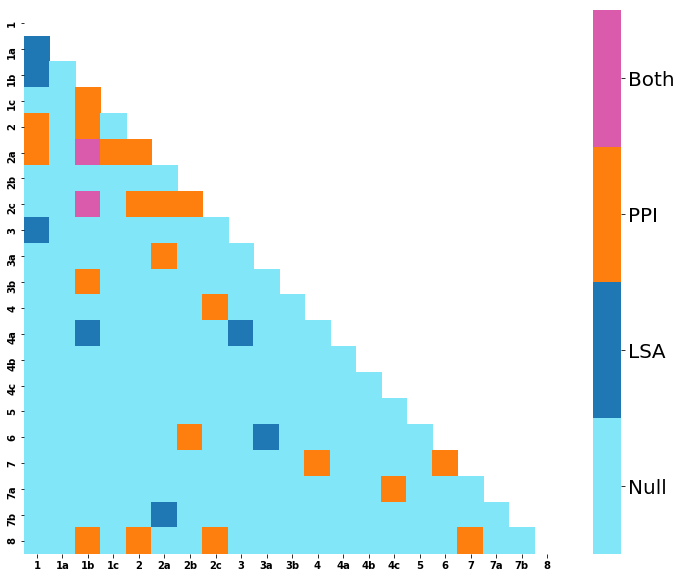

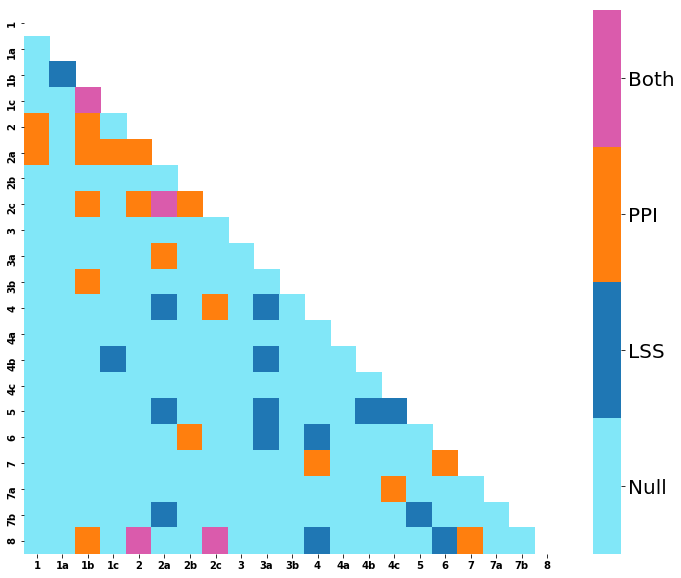

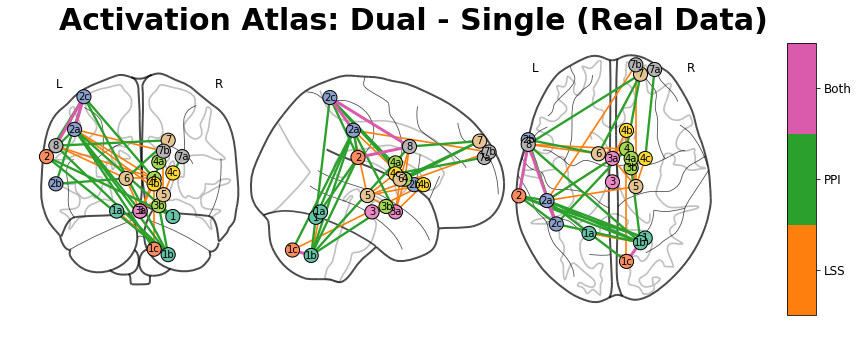

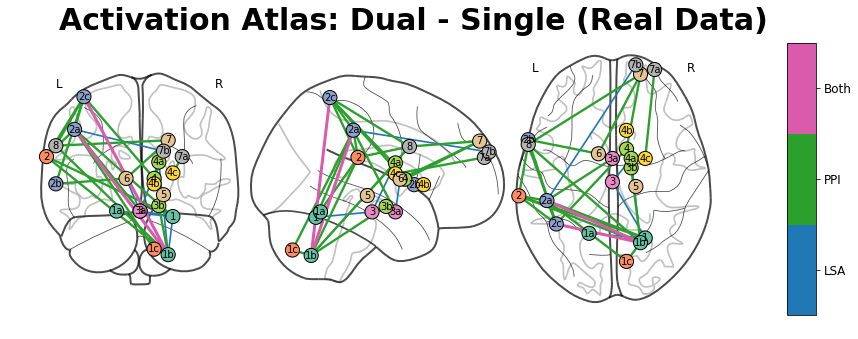

In [23]:
dataframe_estimates.append(
    analyze_data(
        ts_act_ppi_dualxsingle,
        ts_act_lss_dualxsingle,
        ts_act_lsa_dualxsingle,
        "real",
        result_collector,
        correlation_collector,
        "dualxsingle",
        "activation",
        coords_df,
    )
)

## Activation Atlas: Dual - Single (Null Data)

Number of Positives lsa: 11 / 210
Number of Positives ppi: 20 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 9 / 210
Number of Positives ppi: 20 / 210
Number of overlapping positives: 4 / 210
[[1.         0.43325683 0.42297513]
 [0.43325683 1.         0.70047518]
 [0.42297513 0.70047518 1.        ]]


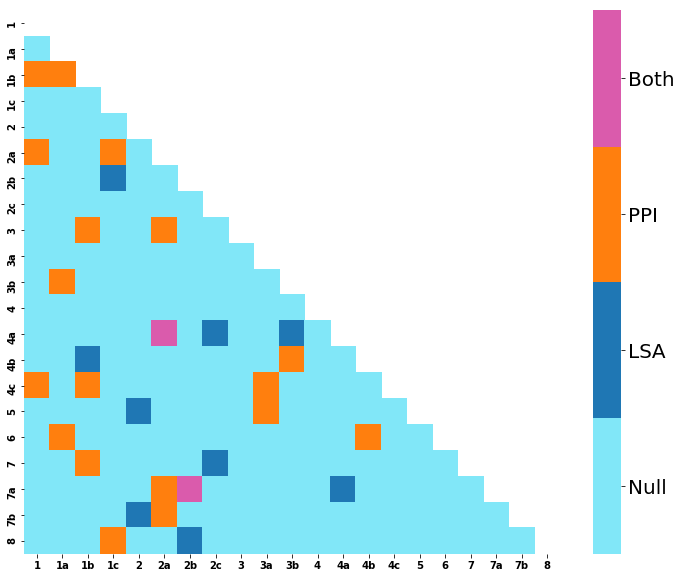

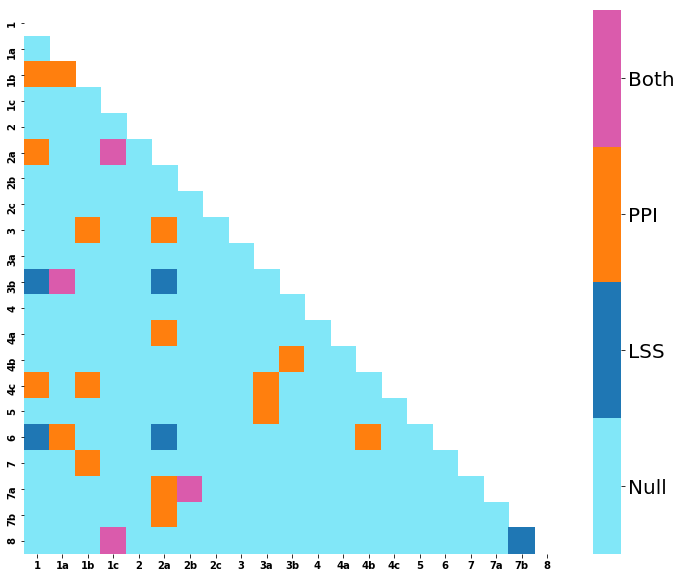

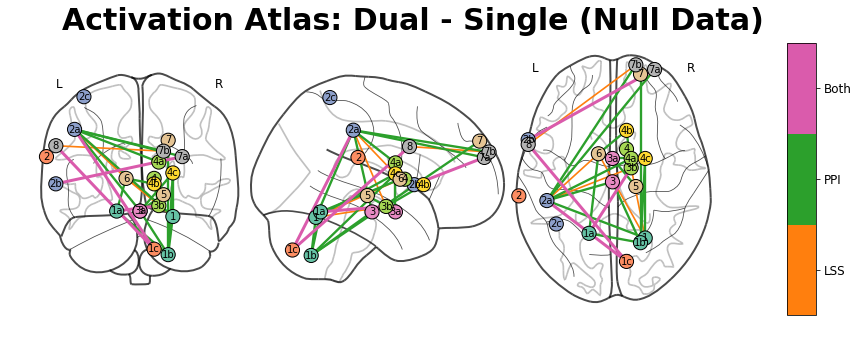

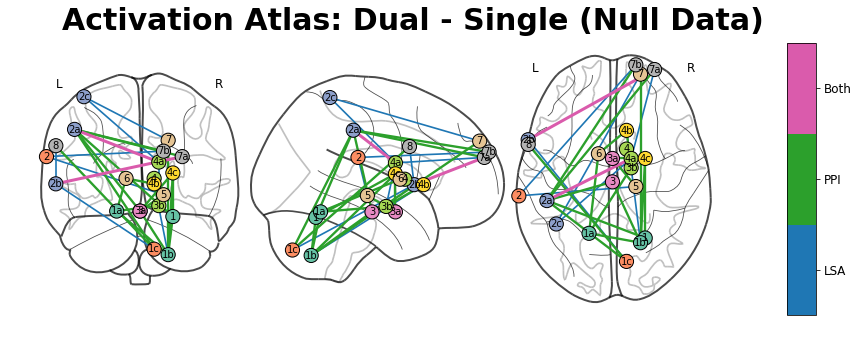

In [24]:
dataframe_estimates.append(
    analyze_data(
        fb_act_ppi_dualxsingle,
        fb_act_lss_dualxsingle,
        fb_act_lsa_dualxsingle,
        "null",
        result_collector,
        correlation_collector,
        "dualxsingle",
        "activation",
        coords_df,
    )
)

## Activation Atlas: Repeat - Single (Real Data)

Number of Positives lsa: 21 / 210
Number of Positives ppi: 25 / 210
Number of overlapping positives: 4 / 210
Number of Positives lss: 16 / 210
Number of Positives ppi: 25 / 210
Number of overlapping positives: 4 / 210
[[1.         0.31260691 0.22934983]
 [0.31260691 1.         0.56167524]
 [0.22934983 0.56167524 1.        ]]


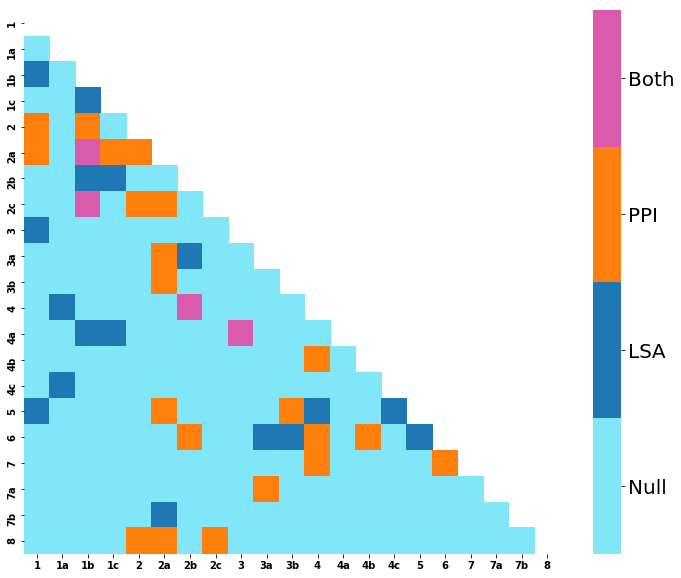

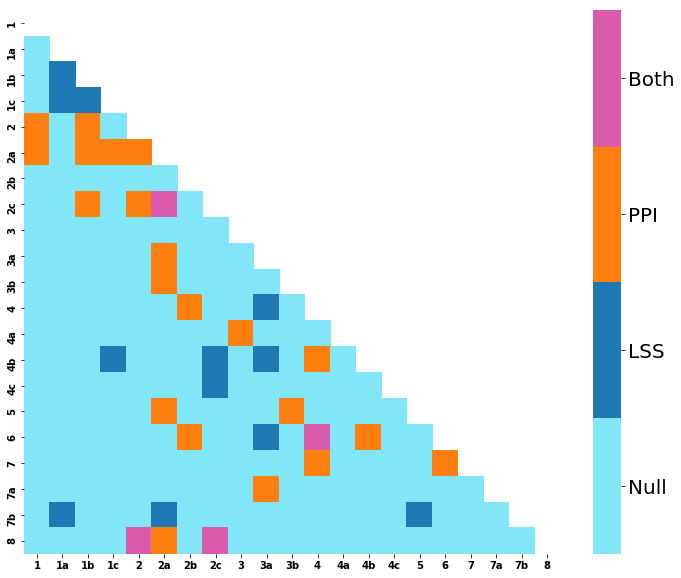

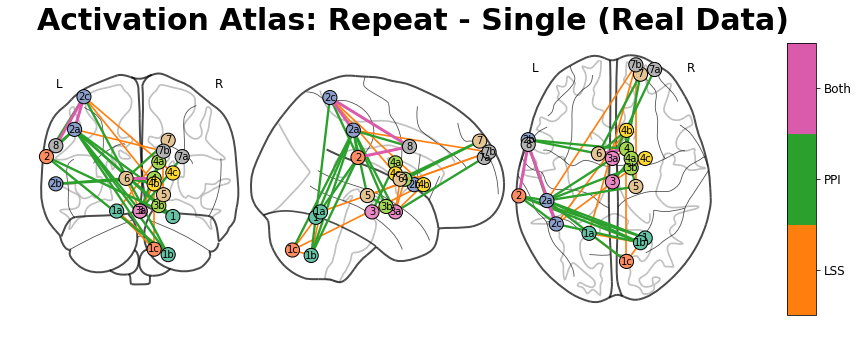

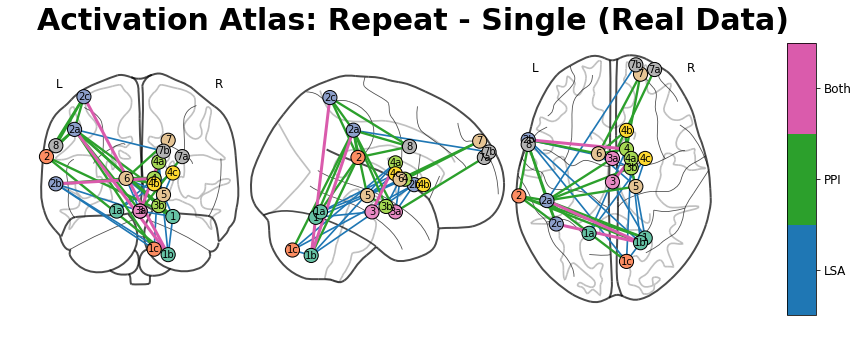

In [25]:
dataframe_estimates.append(
    analyze_data(
        ts_act_ppi_repeatxsingle,
        ts_act_lss_repeatxsingle,
        ts_act_lsa_repeatxsingle,
        "real",
        result_collector,
        correlation_collector,
        "repeatxsingle",
        "activation",
        coords_df,
    )
)

## Activation Atlas: Repeat - Single (Null Data)

Number of Positives lsa: 10 / 210
Number of Positives ppi: 24 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 12 / 210
Number of Positives ppi: 24 / 210
Number of overlapping positives: 5 / 210
[[1.         0.440006   0.39759459]
 [0.440006   1.         0.69317566]
 [0.39759459 0.69317566 1.        ]]


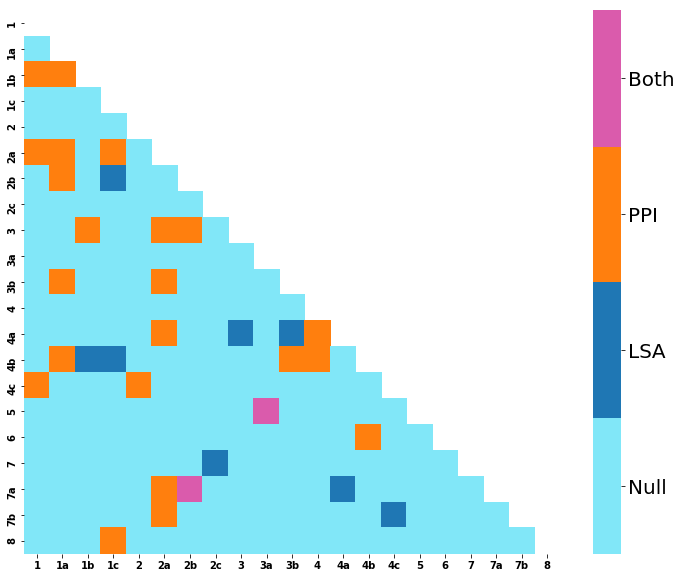

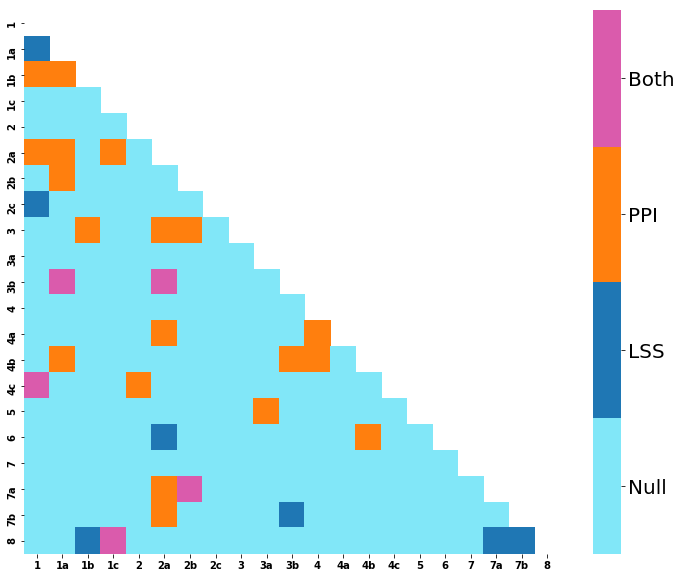

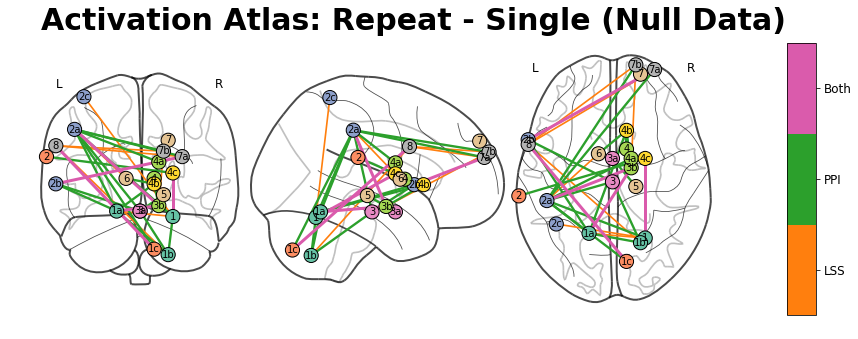

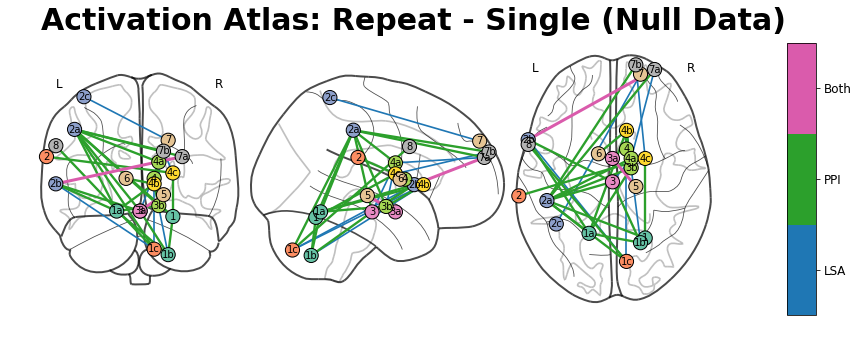

In [26]:
dataframe_estimates.append(
    analyze_data(
        fb_act_ppi_repeatxsingle,
        fb_act_lss_repeatxsingle,
        fb_act_lsa_repeatxsingle,
        "null",
        result_collector,
        correlation_collector,
        "repeatxsingle",
        "activation",
        coords_df,
    )
)

## Activation Atlas: Switch - Repeat (Real Data)

Number of Positives lsa: 15 / 210
Number of Positives ppi: 18 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 6 / 210
Number of Positives ppi: 18 / 210
Number of overlapping positives: 1 / 210
[[1.         0.29343153 0.22671906]
 [0.29343153 1.         0.47083959]
 [0.22671906 0.47083959 1.        ]]


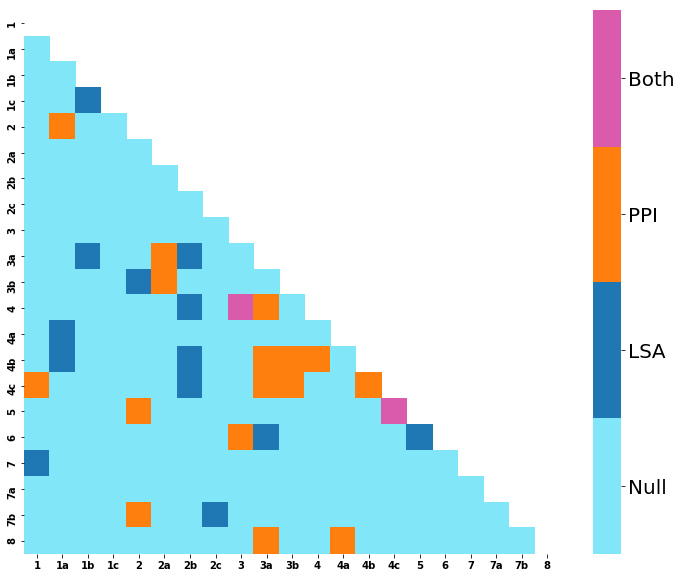

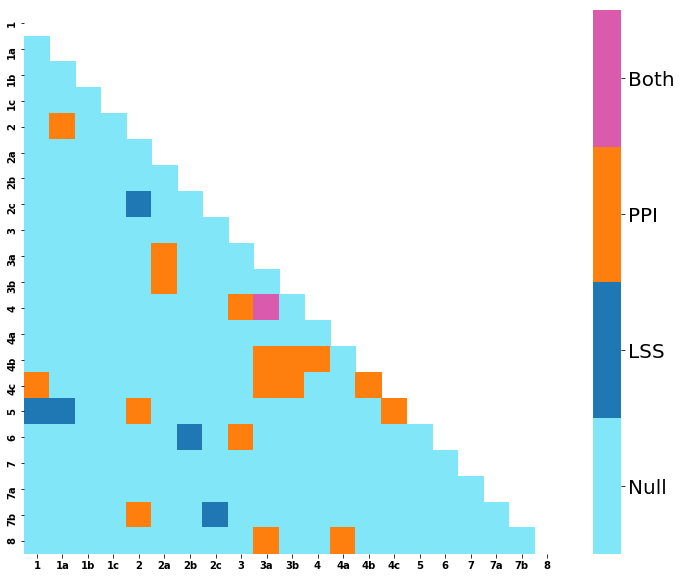

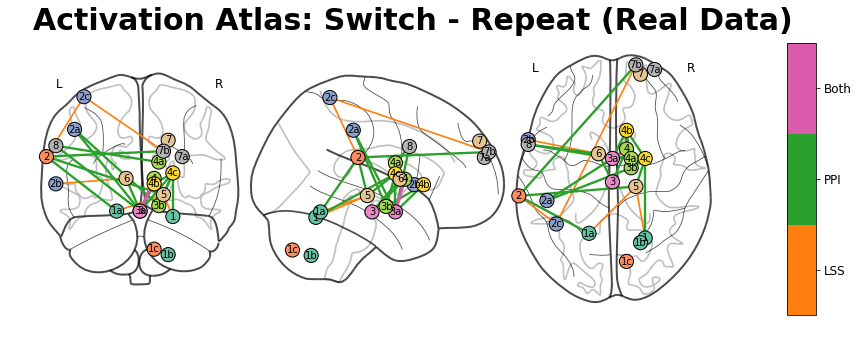

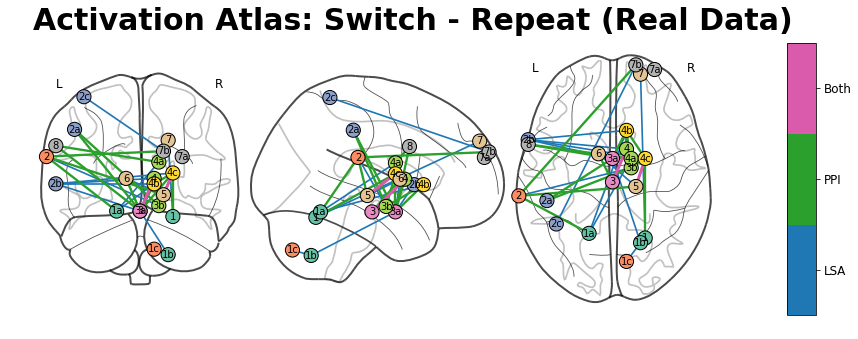

In [27]:
dataframe_estimates.append(
    analyze_data(
        ts_act_ppi_switchxrepeat,
        ts_act_lss_switchxrepeat,
        ts_act_lsa_switchxrepeat,
        "real",
        result_collector,
        correlation_collector,
        "switchxrepeat",
        "activation",
        coords_df,
    )
)

## Activation Atlas: Switch - Repeat (Null Data)

Number of Positives lsa: 12 / 210
Number of Positives ppi: 13 / 210
Number of overlapping positives: 1 / 210
Number of Positives lss: 3 / 210
Number of Positives ppi: 13 / 210
Number of overlapping positives: 1 / 210
[[1.         0.24442152 0.25035555]
 [0.24442152 1.         0.43974041]
 [0.25035555 0.43974041 1.        ]]


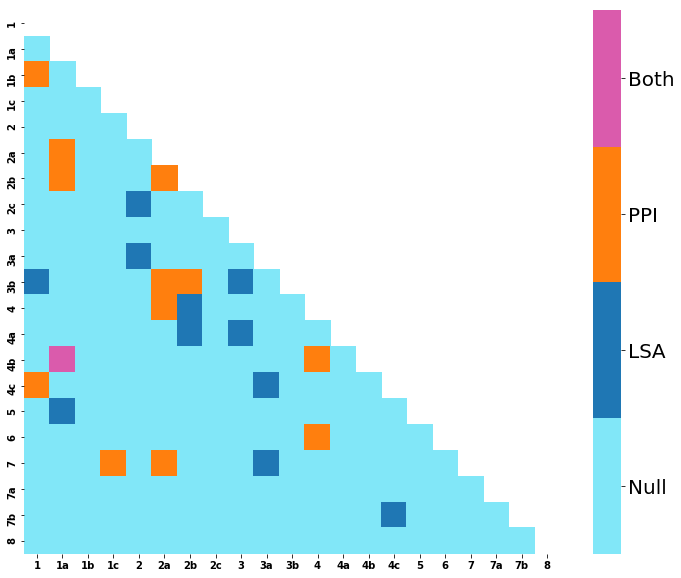

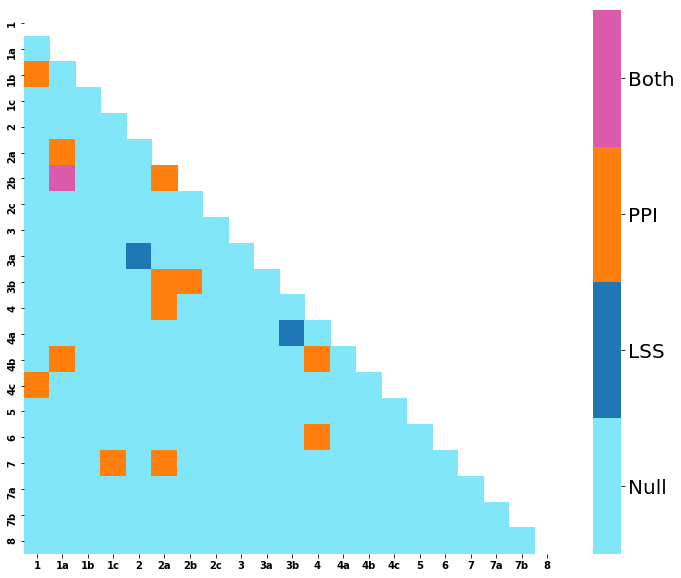

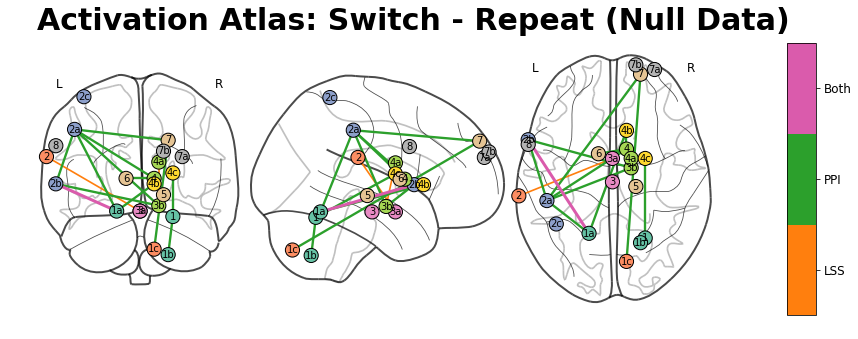

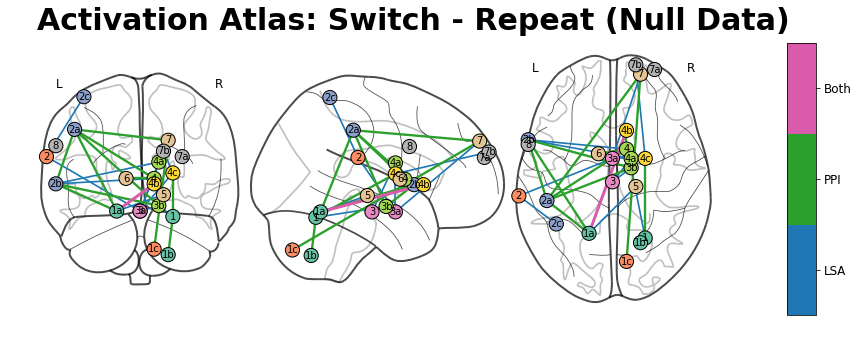

In [28]:
dataframe_estimates.append(
    analyze_data(
        fb_act_ppi_switchxrepeat,
        fb_act_lss_switchxrepeat,
        fb_act_lsa_switchxrepeat,
        "null",
        result_collector,
        correlation_collector,
        "switchxrepeat",
        "activation",
        coords_df,
    )
)

## Schaefer Analysis Prep

In [29]:
# regions with the best CNR
import pickle
with open('../nibsAnalysis/outputs/schaefer_best_cnr.pkl', "rb") as fp:
    best_regions_orig = pickle.load(fp)
best_regions = [nf._flip_hemisphere_network(w) for w in best_regions_orig]
best_regions.sort()
best_regions

['ContA-LH_IPS_1',
 'DefaultA-LH_PCC_6',
 'DefaultC-LH_PHC_1',
 'Limbic-LH_OFC_3',
 'Limbic-LH_TempPole_2',
 'Limbic-LH_TempPole_7',
 'Limbic-RH_OFC_3',
 'Limbic-RH_OFC_5',
 'Limbic-RH_TempPole_5',
 'VisCent-LH_ExStr_3',
 'VisCent-LH_ExStr_4',
 'VisCent-LH_ExStr_5',
 'VisCent-LH_ExStr_7',
 'VisCent-RH_ExStr_2',
 'VisCent-RH_ExStr_4',
 'VisCent-RH_ExStr_5',
 'VisCent-RH_ExStr_6',
 'VisCent-RH_ExStr_7',
 'VisCent-RH_ExStr_9',
 'VisPeri-LH_ExStrSup_6']

In [30]:
names = ["ROI Index", "Label Name", "r", "g", "b", "a"]
schaefer_color_fname = "https://raw.githubusercontent.com/ThomasYeoLab/CBIG/fa00f88b0d50fef74abf6748f03d5384bd39efd7/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_400Parcels_17Networks_order.txt"
schaefer_color_lut = pd.read_csv(schaefer_color_fname, names=names, sep='\t')

schaefer_atlas_centroid_fname = "https://raw.githubusercontent.com/ThomasYeoLab/CBIG/fa00f88b0d50fef74abf6748f03d5384bd39efd7/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.Centroid_RAS.csv"
schaefer_centroid_coords = pd.read_csv(schaefer_atlas_centroid_fname)

schaefer_info = pd.merge(schaefer_centroid_coords, schaefer_color_lut, on=["ROI Index", "Label Name"], how="inner")

schaefer_info.replace(
    r'17Networks_([RL]H)_([A-Za-z]+)_([A-Za-z]+)_([0-9]+)',
    r'\1-\2-\3_\4',
    regex=True,
    inplace=True)

schaeferbest_info = schaefer_info[schaefer_info['Label Name'].isin(best_regions_orig)]
schaeferbest_info.rename(columns={"R": "X", "A": "Y", "S": "Z"}, inplace=True)
schaeferbest_info['best_regions'] = schaeferbest_info["Label Name"].apply(nf._flip_hemisphere_network)
schaeferbest_info.sort_values(by='best_regions', inplace=True)
schaeferbest_info

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexin

ROI Index             Label Name     X     Y     Z    r    g    b  a  \
121        122         LH-ContA-IPS_1 -29.0 -74.0  42.0  230  148   34  0   
158        159      LH-DefaultA-PCC_6  -3.0 -68.0  41.0  255  254    6  0   
191        192      LH-DefaultC-PHC_1 -21.0 -21.0 -26.0    0    1  131  0   
110        111        LH-Limbic-OFC_3 -10.0  47.0 -21.0  122  135   52  0   
114        115   LH-Limbic-TempPole_2 -25.0   6.0 -39.0  220  248  163  0   
119        120   LH-Limbic-TempPole_7 -44.0   5.0 -17.0  220  248  169  0   
314        315        RH-Limbic-OFC_3   8.0  47.0 -23.0  126  135   53  0   
316        317        RH-Limbic-OFC_5   5.0  22.0 -21.0  126  135   55  0   
322        323   RH-Limbic-TempPole_5  29.0  12.0 -30.0  224  248  169  0   
2            3     LH-VisCent-ExStr_3 -36.0 -81.0 -16.0  120   18  133  0   
3            4     LH-VisCent-ExStr_4 -17.0 -86.0 -15.0  120   18  134  0   
4            5     LH-VisCent-ExStr_5 -24.0 -97.0 -12.0  120   18  136  0   
6            7     LH-VisCent-ExStr_7  -7.0 -98.0  -7.0  120   18  138  0   
201        202     RH-VisCent-ExStr_2  37.0 -73.0 -16.0  124   19  132  0   
203        204     RH-VisCent-ExStr_4  20.0 -88.0 -13.0  124   19  134  0   
204        205     RH-VisCent-ExStr_5  42.0 -84.0 -12.0  124   19  136  0   
205        206     RH-VisCent-ExStr_6  25.0 -97.0 -10.0  124   19  137  0   
206        207     RH-VisCent-ExStr_7   8.0 -92.0  -2.0  124   19  138  0   
208        209     RH-VisCent-ExStr_9  24.0 -99.0   7.0  124   19  140  0   
17          18  LH-VisPeri-ExStrSup_6  -5.0 -88.0   2.0  255    1    6  0   

              best_regions  
121         ContA-LH_IPS_1  
158      DefaultA-LH_PCC_6  
191      DefaultC-LH_PHC_1  
110        Limbic-LH_OFC_3  
114   Limbic-LH_TempPole_2  
119   Limbic-LH_TempPole_7  
314        Limbic-RH_OFC_3  
316        Limbic-RH_OFC_5  
322   Limbic-RH_TempPole_5  
2       VisCent-LH_ExStr_3  
3       VisCent-LH_ExStr_4  
4       VisCent-LH_ExStr_5  
6       VisCent-LH_ExStr_7  
201     VisCent-RH_ExStr_2  
203     VisCent-RH_ExStr_4  
204     VisCent-RH_ExStr_5  
205     VisCent-RH_ExStr_6  
206     VisCent-RH_ExStr_7  
208     VisCent-RH_ExStr_9  
17   VisPeri-LH_ExStrSup_6

## Schaefer Atlas: Dual - Single (Real Data)

Number of Positives lsa: 8069 / 79800
Number of Positives ppi: 13362 / 79800
Number of overlapping positives: 2016 / 79800
Number of Positives lss: 7723 / 79800
Number of Positives ppi: 13362 / 79800
Number of overlapping positives: 3636 / 79800
schaeferbest lss x ppi overlap:  10
schaeferbest lsa x ppi overlap:  8
schaeferbest ppi sig:  51
schaeferbest lss sig:  20
schaeferbest lsa sig:  15
Schaefer Top 20
[[1.         0.51478932 0.31476519]
 [0.51478932 1.         0.59088478]
 [0.31476519 0.59088478 1.        ]]
Schaefer Full
[[1.         0.37685651 0.26604449]
 [0.37685651 1.         0.57812522]
 [0.26604449 0.57812522 1.        ]]


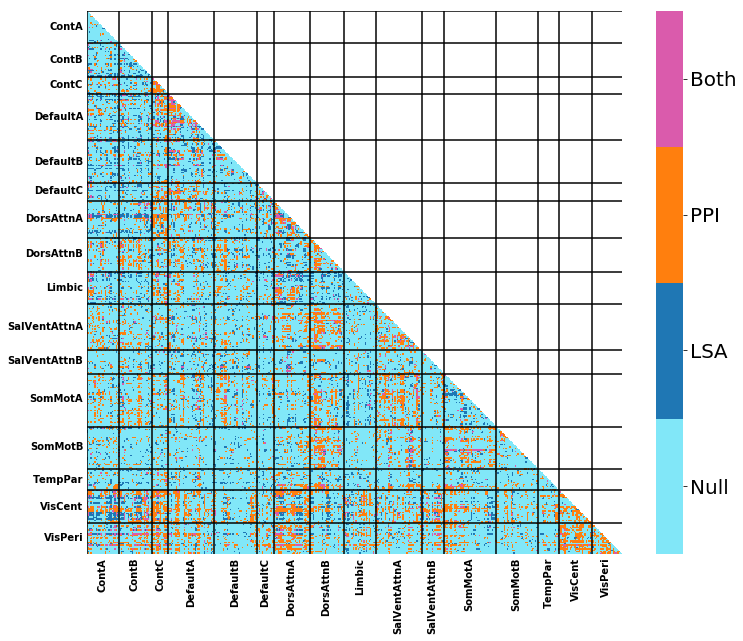

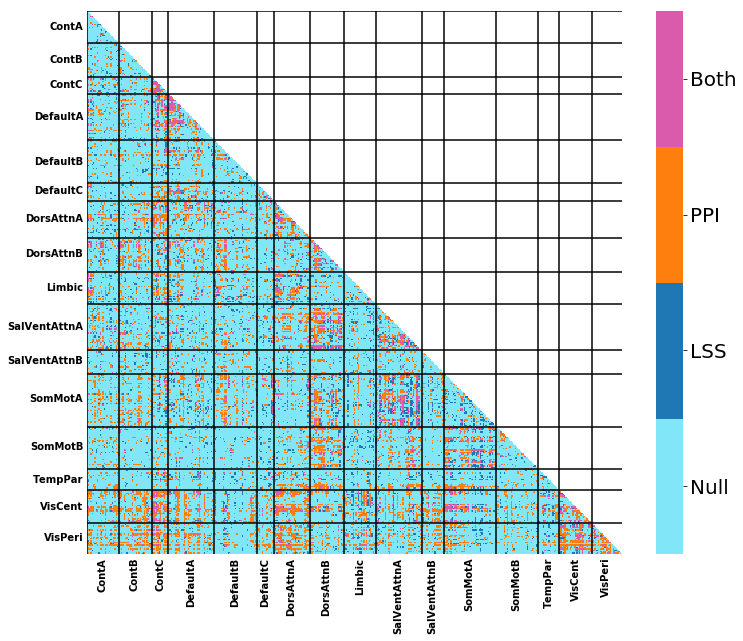

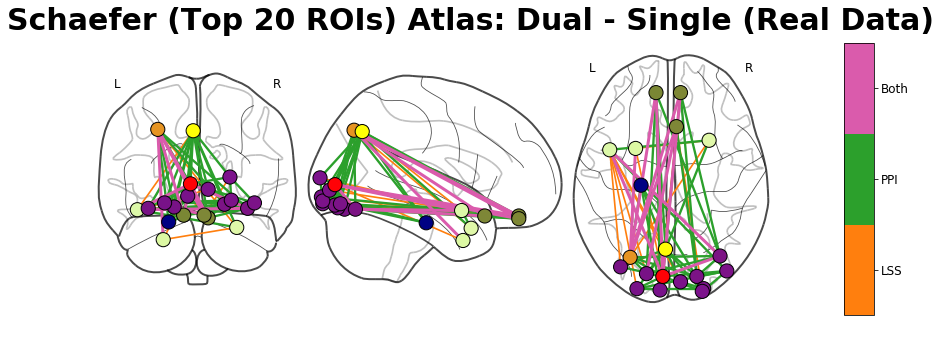

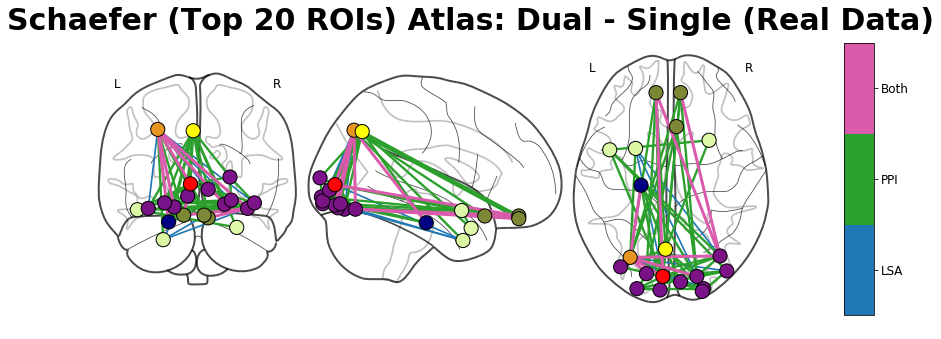

In [31]:
dataframe_estimates.append(
    analyze_data(
        ts_sch_ppi_dualxsingle,
        ts_sch_lss_dualxsingle,
        ts_sch_lsa_dualxsingle,
        "real",
        result_collector,
        correlation_collector,
        "dualxsingle",
        "schaefer",
        schaeferbest_info,
        best_regions=best_regions,
        best_regions_orig=best_regions_orig,
    )
)

## Schaefer Atlas: Dual - Single (Null Data)

Number of Positives lsa: 6384 / 79800
Number of Positives ppi: 11184 / 79800
Number of overlapping positives: 1705 / 79800
Number of Positives lss: 8213 / 79800
Number of Positives ppi: 11184 / 79800
Number of overlapping positives: 3640 / 79800
schaeferbest lss x ppi overlap:  5
schaeferbest lsa x ppi overlap:  3
schaeferbest ppi sig:  26
schaeferbest lss sig:  7
schaeferbest lsa sig:  17
Schaefer Top 20
[[1.         0.27815947 0.27041696]
 [0.27815947 1.         0.60456574]
 [0.27041696 0.60456574 1.        ]]
Schaefer Full
[[1.         0.46815158 0.42036584]
 [0.46815158 1.         0.6868498 ]
 [0.42036584 0.6868498  1.        ]]


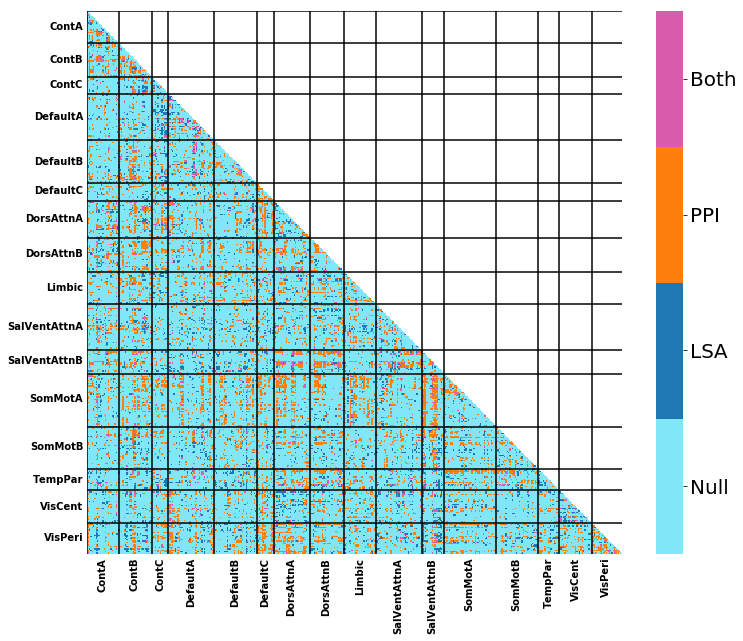

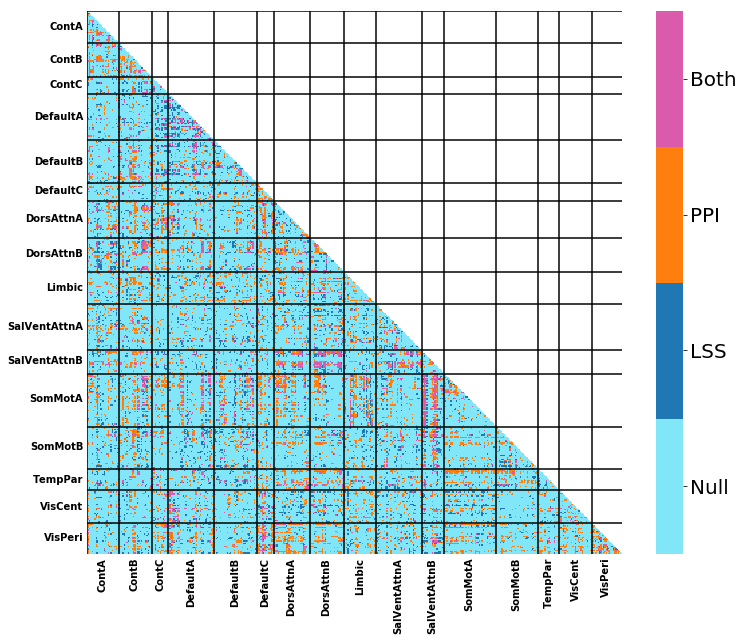

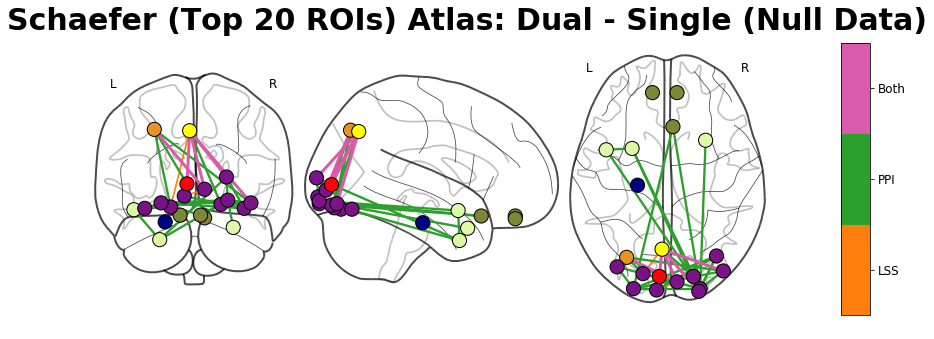

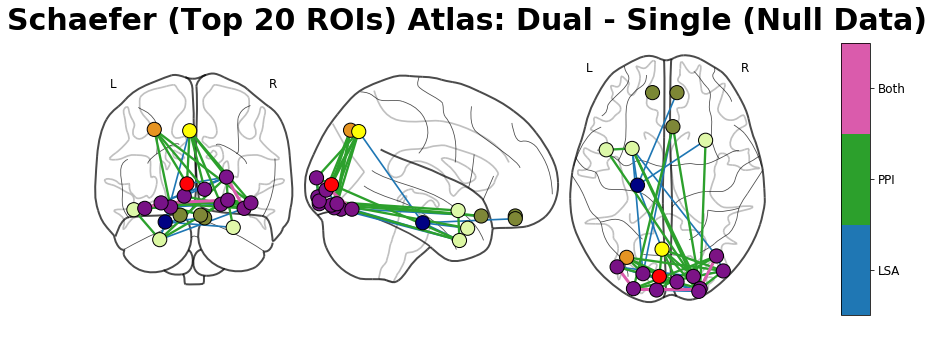

In [32]:
dataframe_estimates.append(
    analyze_data(
        fb_sch_ppi_dualxsingle,
        fb_sch_lss_dualxsingle,
        fb_sch_lsa_dualxsingle,
        "null",
        result_collector,
        correlation_collector,
        "dualxsingle",
        "schaefer",
        schaeferbest_info,
        best_regions=best_regions,
        best_regions_orig=best_regions_orig,
    )
)

## Schaefer Atlas: Repeat - Single (Real Data)

Number of Positives lsa: 9145 / 79800
Number of Positives ppi: 12895 / 79800
Number of overlapping positives: 2140 / 79800
Number of Positives lss: 7631 / 79800
Number of Positives ppi: 12895 / 79800
Number of overlapping positives: 3773 / 79800
schaeferbest lss x ppi overlap:  10
schaeferbest lsa x ppi overlap:  12
schaeferbest ppi sig:  59
schaeferbest lss sig:  21
schaeferbest lsa sig:  24
Schaefer Top 20
[[1.         0.52712353 0.42064284]
 [0.52712353 1.         0.67288394]
 [0.42064284 0.67288394 1.        ]]
Schaefer Full
[[1.         0.36220345 0.2700873 ]
 [0.36220345 1.         0.61879456]
 [0.2700873  0.61879456 1.        ]]


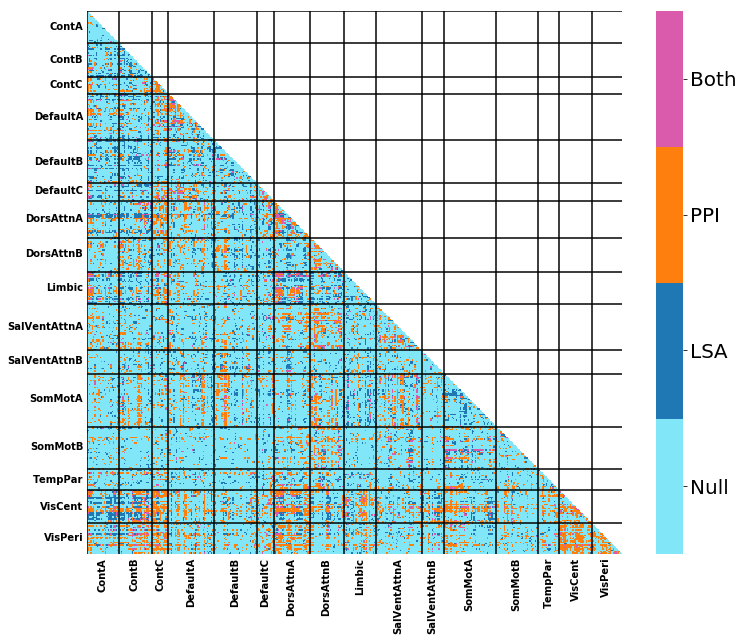

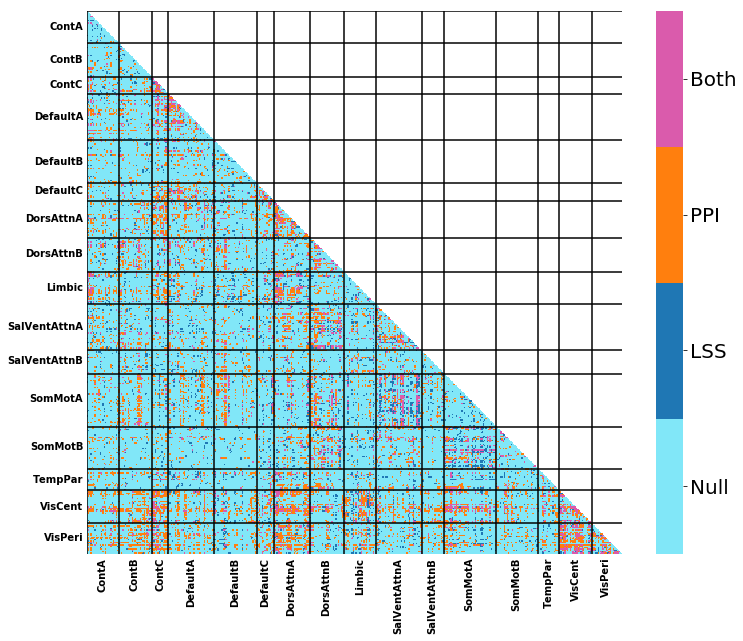

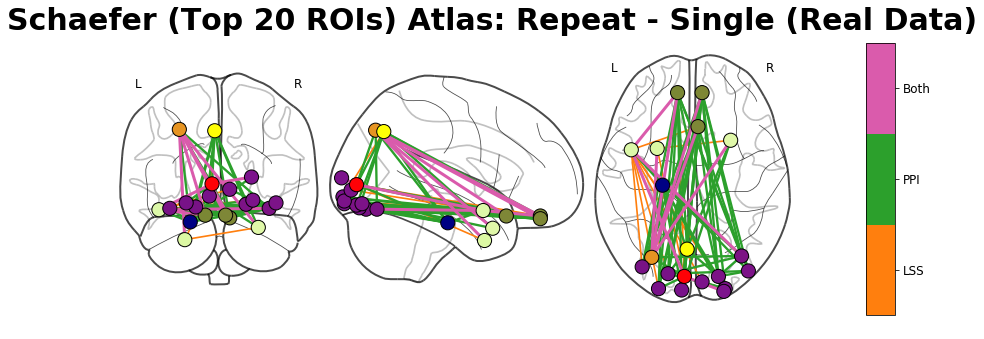

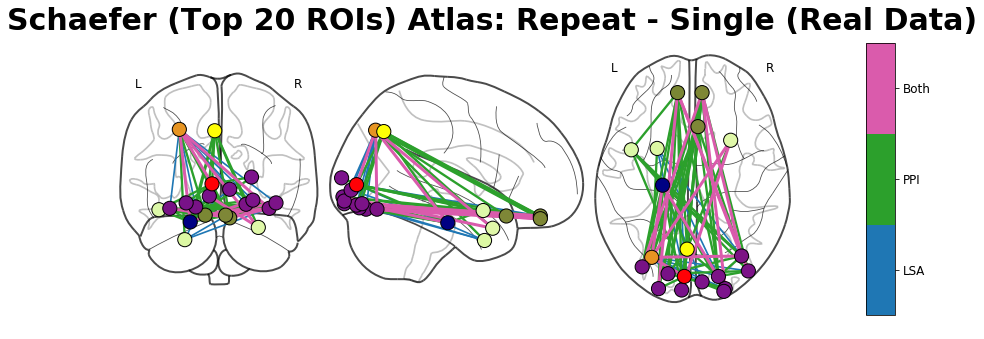

In [33]:
dataframe_estimates.append(
    analyze_data(
        ts_sch_ppi_repeatxsingle,
        ts_sch_lss_repeatxsingle,
        ts_sch_lsa_repeatxsingle,
        "real",
        result_collector,
        correlation_collector,
        "repeatxsingle",
        "schaefer",
        schaeferbest_info,
        best_regions=best_regions,
        best_regions_orig=best_regions_orig,
    )
)

## Schaefer Atlas: Repeat - Single (Null Data)

Number of Positives lsa: 6762 / 79800
Number of Positives ppi: 11375 / 79800
Number of overlapping positives: 1896 / 79800
Number of Positives lss: 8461 / 79800
Number of Positives ppi: 11375 / 79800
Number of overlapping positives: 4089 / 79800
schaeferbest lss x ppi overlap:  4
schaeferbest lsa x ppi overlap:  2
schaeferbest ppi sig:  24
schaeferbest lss sig:  9
schaeferbest lsa sig:  24
Schaefer Top 20
[[1.         0.13824622 0.23725042]
 [0.13824622 1.         0.69201892]
 [0.23725042 0.69201892 1.        ]]
Schaefer Full
[[1.         0.46921821 0.41648274]
 [0.46921821 1.         0.70366855]
 [0.41648274 0.70366855 1.        ]]


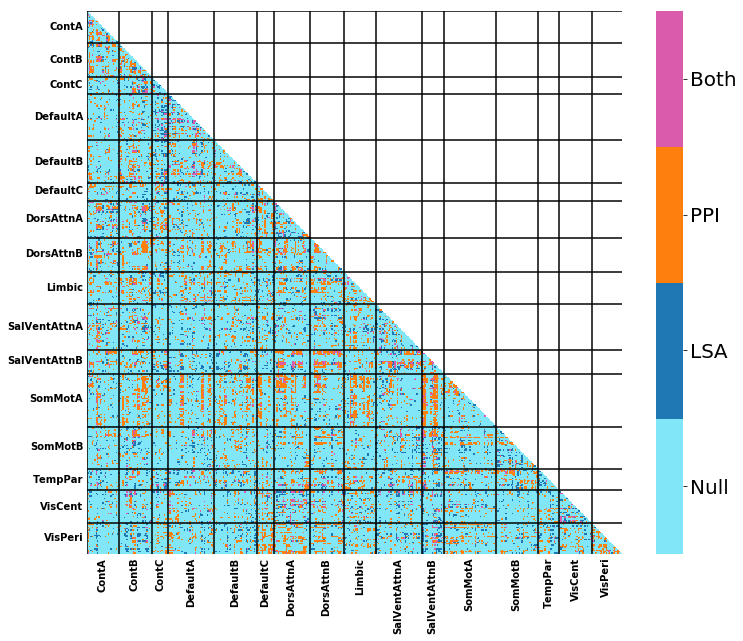

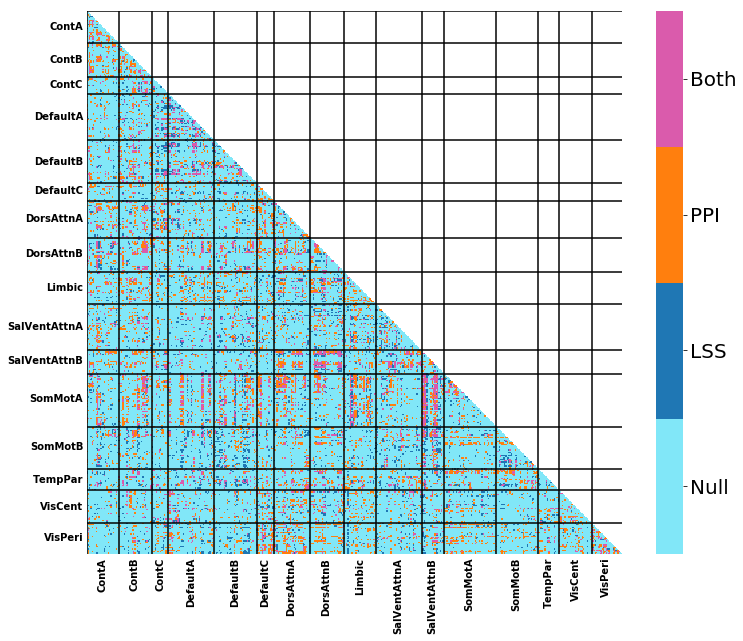

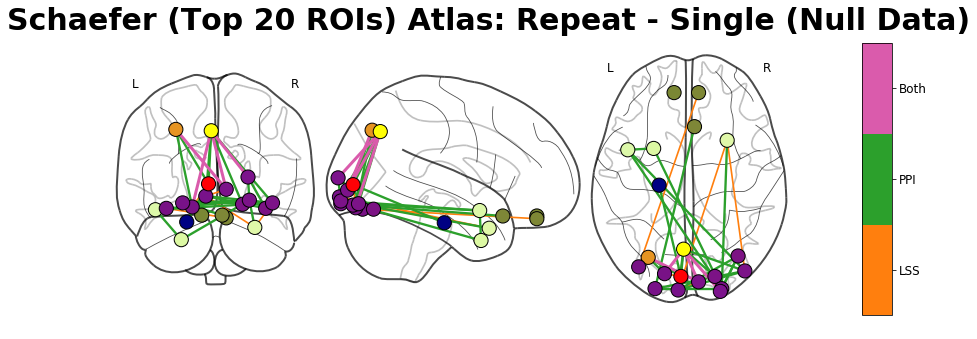

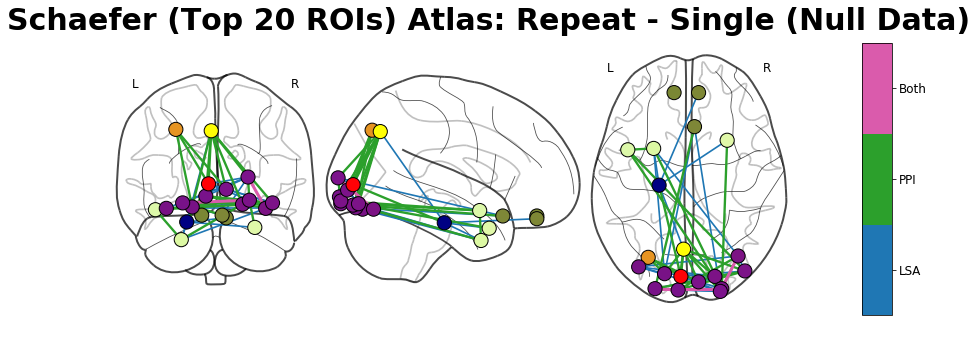

In [34]:
dataframe_estimates.append(
    analyze_data(
        fb_sch_ppi_repeatxsingle,
        fb_sch_lss_repeatxsingle,
        fb_sch_lsa_repeatxsingle,
        "null",
        result_collector,
        correlation_collector,
        "repeatxsingle",
        "schaefer",
        schaeferbest_info,
        best_regions=best_regions,
        best_regions_orig=best_regions_orig,
    )
)

## Schaefer Atlas: Switch - Repeat (Real Data)

Number of Positives lsa: 5153 / 79800
Number of Positives ppi: 3947 / 79800
Number of overlapping positives: 388 / 79800
Number of Positives lss: 3462 / 79800
Number of Positives ppi: 3947 / 79800
Number of overlapping positives: 406 / 79800
schaeferbest lss x ppi overlap:  1
schaeferbest lsa x ppi overlap:  1
schaeferbest ppi sig:  13
schaeferbest lss sig:  8
schaeferbest lsa sig:  8
Schaefer Top 20
[[1.         0.25164114 0.22583531]
 [0.25164114 1.         0.17256221]
 [0.22583531 0.17256221 1.        ]]
Schaefer Full
[[1.         0.30009307 0.1683753 ]
 [0.30009307 1.         0.39020495]
 [0.1683753  0.39020495 1.        ]]


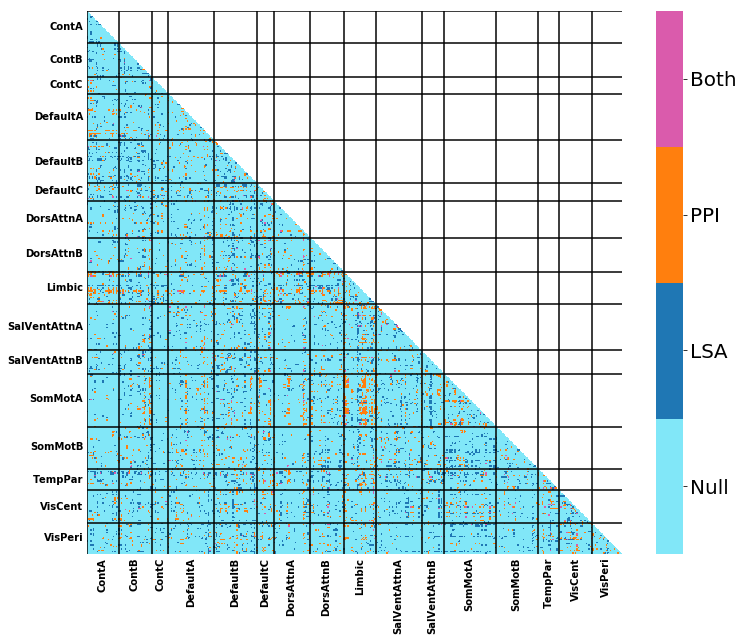

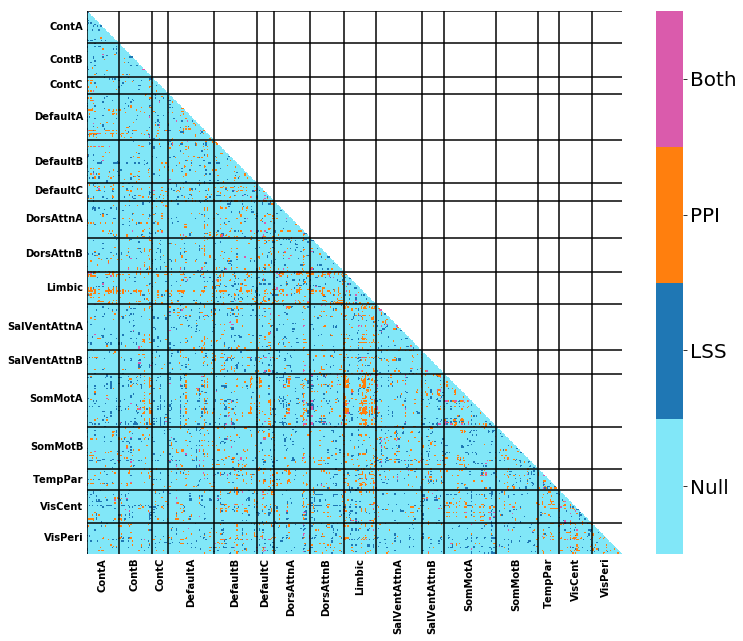

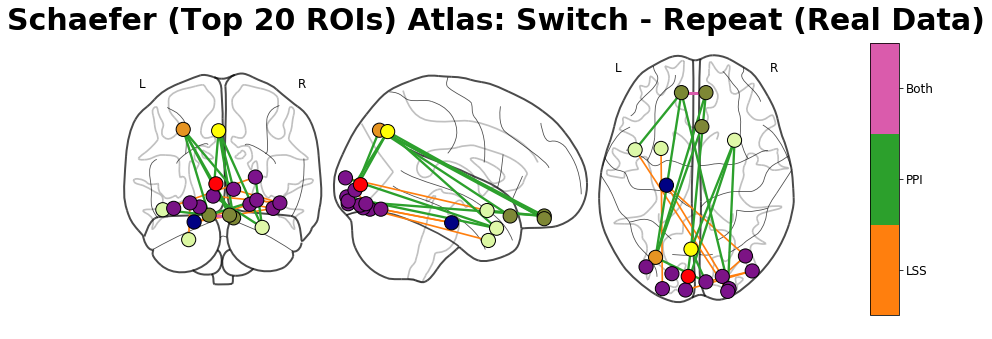

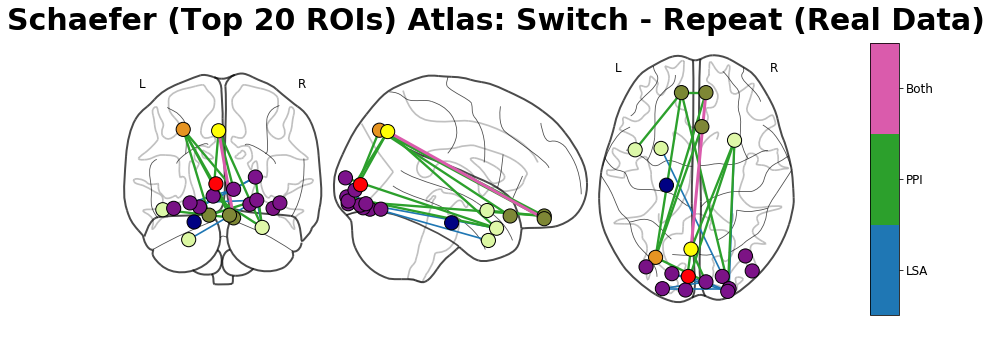

In [35]:
dataframe_estimates.append(
    analyze_data(
        ts_sch_ppi_switchxrepeat,
        ts_sch_lss_switchxrepeat,
        ts_sch_lsa_switchxrepeat,
        "real",
        result_collector,
        correlation_collector,
        "switchxrepeat",
        "schaefer",
        schaeferbest_info,
        best_regions=best_regions,
        best_regions_orig=best_regions_orig,
    )
)

## Schaefer Atlas: Switch - Repeat (Null Data)

Number of Positives lsa: 3904 / 79800
Number of Positives ppi: 5037 / 79800
Number of overlapping positives: 511 / 79800
Number of Positives lss: 4443 / 79800
Number of Positives ppi: 5037 / 79800
Number of overlapping positives: 779 / 79800
schaeferbest lss x ppi overlap:  1
schaeferbest lsa x ppi overlap:  1
schaeferbest ppi sig:  10
schaeferbest lss sig:  6
schaeferbest lsa sig:  30
Schaefer Top 20
[[1.         0.20114675 0.19022264]
 [0.20114675 1.         0.35198298]
 [0.19022264 0.35198298 1.        ]]
Schaefer Full
[[1.         0.28500166 0.26550517]
 [0.28500166 1.         0.4138742 ]
 [0.26550517 0.4138742  1.        ]]


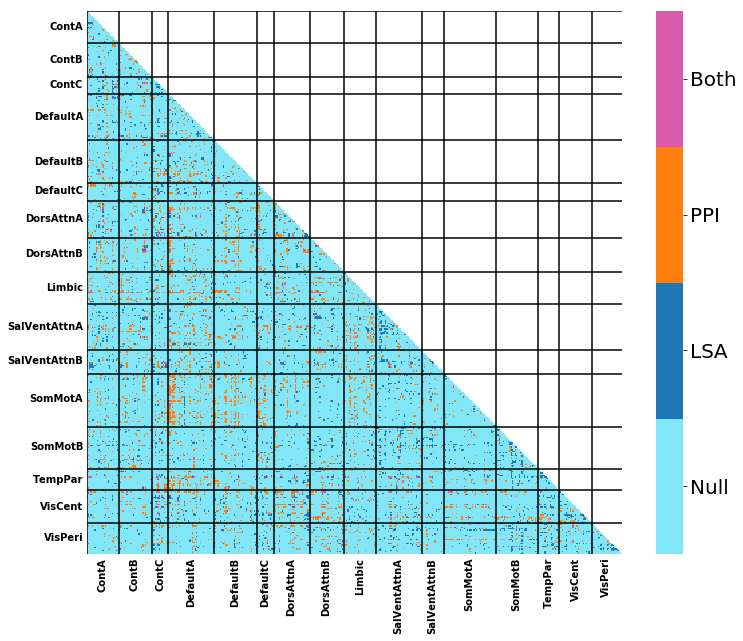

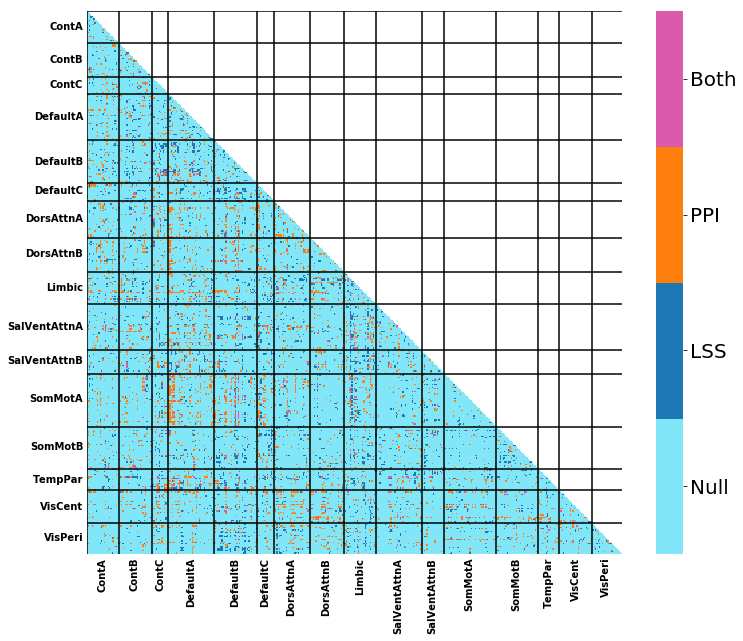

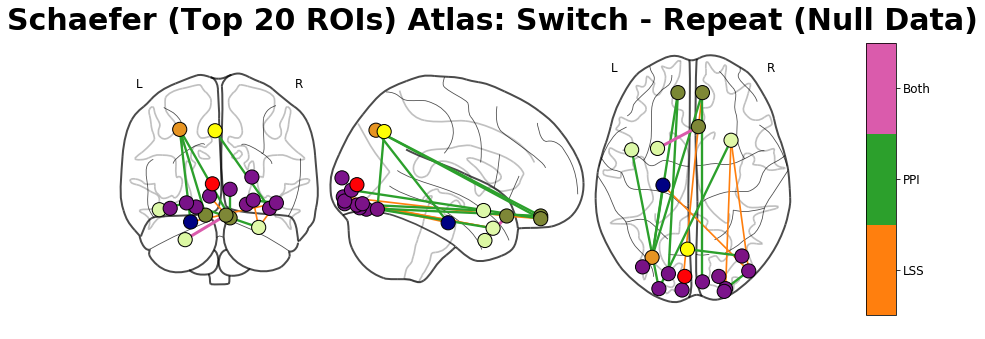

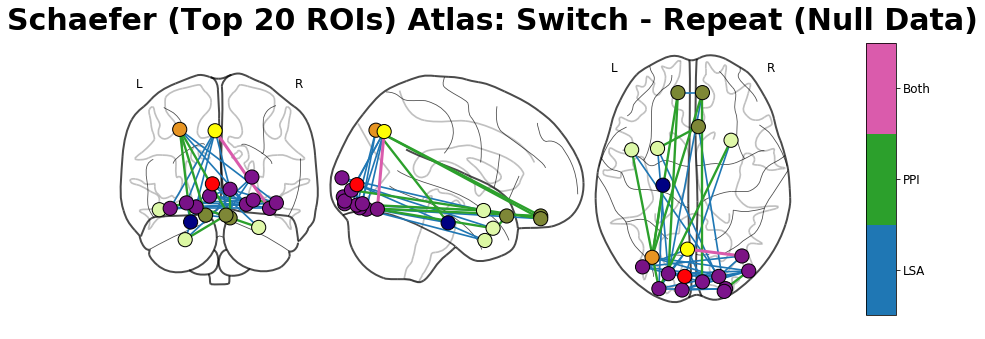

In [36]:
dataframe_estimates.append(
    analyze_data(
        fb_sch_ppi_switchxrepeat,
        fb_sch_lss_switchxrepeat,
        fb_sch_lsa_switchxrepeat,
        "null",
        result_collector,
        correlation_collector,
        "switchxrepeat",
        "schaefer",
        schaeferbest_info,
        best_regions=best_regions,
        best_regions_orig=best_regions_orig,
    )
)

## Analysis Overview

In [37]:
result_df = pd.DataFrame.from_dict(result_collector)
result_df.to_csv('./outputs/observed_significance_results.tsv', sep='\t')

In [38]:
result_df

atlas  data       contrast estimator participants  observed_value  \
0     activation  real    dualxsingle       ppi     filtered              22   
1     activation  real    dualxsingle       lss     filtered              19   
2     activation  real    dualxsingle       lsa     filtered               9   
3     activation  null    dualxsingle       ppi     filtered              20   
4     activation  null    dualxsingle       lss     filtered               9   
5     activation  null    dualxsingle       lsa     filtered              11   
6     activation  real  repeatxsingle       ppi     filtered              25   
7     activation  real  repeatxsingle       lss     filtered              16   
8     activation  real  repeatxsingle       lsa     filtered              21   
9     activation  null  repeatxsingle       ppi     filtered              24   
10    activation  null  repeatxsingle       lss     filtered              12   
11    activation  null  repeatxsingle       lsa     filtered              10   
12    activation  real  switchxrepeat       ppi     filtered              18   
13    activation  real  switchxrepeat       lss     filtered               6   
14    activation  real  switchxrepeat       lsa     filtered              15   
15    activation  null  switchxrepeat       ppi     filtered              13   
16    activation  null  switchxrepeat       lss     filtered               3   
17    activation  null  switchxrepeat       lsa     filtered              12   
18  schaeferbest  real    dualxsingle       ppi     filtered              51   
19  schaeferbest  real    dualxsingle       lss     filtered              20   
20  schaeferbest  real    dualxsingle       lsa     filtered              15   
21      schaefer  real    dualxsingle       ppi     filtered           13362   
22      schaefer  real    dualxsingle       lss     filtered            7723   
23      schaefer  real    dualxsingle       lsa     filtered            8069   
24  schaeferbest  null    dualxsingle       ppi     filtered              26   
25  schaeferbest  null    dualxsingle       lss     filtered               7   
26  schaeferbest  null    dualxsingle       lsa     filtered              17   
27      schaefer  null    dualxsingle       ppi     filtered           11184   
28      schaefer  null    dualxsingle       lss     filtered            8213   
29      schaefer  null    dualxsingle       lsa     filtered            6384   
30  schaeferbest  real  repeatxsingle       ppi     filtered              59   
31  schaeferbest  real  repeatxsingle       lss     filtered              21   
32  schaeferbest  real  repeatxsingle       lsa     filtered              24   
33      schaefer  real  repeatxsingle       ppi     filtered           12895   
34      schaefer  real  repeatxsingle       lss     filtered            7631   
35      schaefer  real  repeatxsingle       lsa     filtered            9145   
36  schaeferbest  null  repeatxsingle       ppi     filtered              24   
37  schaeferbest  null  repeatxsingle       lss     filtered               9   
38  schaeferbest  null  repeatxsingle       lsa     filtered              24   
39      schaefer  null  repeatxsingle       ppi     filtered           11375   
40      schaefer  null  repeatxsingle       lss     filtered            8461   
41      schaefer  null  repeatxsingle       lsa     filtered            6762   
42  schaeferbest  real  switchxrepeat       ppi     filtered              13   
43  schaeferbest  real  switchxrepeat       lss     filtered               8   
44  schaeferbest  real  switchxrepeat       lsa     filtered               8   
45      schaefer  real  switchxrepeat       ppi     filtered            3947   
46      schaefer  real  switchxrepeat       lss     filtered            3462   
47      schaefer  real  switchxrepeat       lsa     filtered            5153   
48  schaeferbest  null  switchxrepeat       ppi     filtered              10   
49  schaefe

In [39]:
contrast_order = ['dualxsingle', 'repeatxsingle', 'switchxrepeat']
method_order = ['lsa', 'lss', 'ppi']
def make_summary_plots(contrast_order,
                       method_order,
                       permutation_df,
                       atlas,
                       data,
                       n_roi_roi_pairs,
                       participants="filtered"):
    
    # filter down to the relevant data
    query = "(data == '{data}') & (atlas == '{atlas}') & (participants == '{participants}')".format(
        data=data, atlas=atlas, participants=participants)
    
    permutation_filt_df = permutation_df.query(query)
    
    # create a percentage
    permutation_filt_df['observed_value_percent'] = (permutation_filt_df['observed_value'] / n_roi_roi_pairs) * 100

    # make the figure
    fig, ax = plt.subplots(figsize=(8, 5))

    sns.swarmplot(x='contrast',
                  order=contrast_order,
                  y='observed_value_percent',
                  hue='estimator',
                  hue_order=method_order,
                  dodge=True,
                  size=15,
                  ax=ax,
                  data=permutation_filt_df)

    ax.set_ylim(0, 35)

    # create confidence interval
    lower_confidence, higher_confidence = proportion_confint(n_roi_roi_pairs*0.05, n_roi_roi_pairs)
    ax.axhspan(lower_confidence*100, higher_confidence*100, alpha=0.15,
               facecolor='red', edgecolor=None)

    # set y label
    ax.set_ylabel("Significant ROI-ROI Pairs (%)", weight='heavy', size=15)

    # set x label
    ax.set_xlabel("")

    # set x tick marks
    new_ticks = [s.get_text().replace('x', ' - ') for s in ax.get_xticklabels()]
    ax.set_xticklabels(new_ticks, fontdict={'weight': 'heavy', 'size': 13}, rotation=35)

    # change the alpha of the legend, and make text more visible
    [p.set(alpha=alpha, facecolor=p.get_facecolor()) for p in ax.legend_.get_patches()];
    ax.legend_.set_title("")
    ax.legend_.texts[0].set(size=12, weight='bold')

    # draw false positive line
    ax.axhline(5, color='red', linestyle='--', linewidth=3)
    ax.text(ax.get_xlim()[0] + 0.01, 3.5, "Expected False Positive Rate (5%)", weight='heavy');

    # separate the dot pairs
    category_xval = (ax.get_xticks() + 0.5)[0:-1]
    for xval in category_xval:
        ax.axvline(xval, color='black')

    # change the alpha of the violins
    contrast_orders = [item for item in contrast_order for i in range(len(method_order))]
    method_orders = method_order * len(contrast_order)

    # annotate dots with p-values
    for contrast, method, point in zip(contrast_orders, method_orders, ax.collections[:len(contrast_order) * len(method_order)]):
        df_query = "(estimator == '{method}') & (contrast == '{contrast}')".format(method=method, contrast=contrast)
        p_val = permutation_filt_df.query(df_query)['binom_p_value'].unique()[0]
        # import pdb; pdb.set_trace()
        p_val_round = round(p_val, 3)

        if p_val_round == 0:
            p_str = 'p<{:.3f}'.format(p_val_round + 0.001)
        else:
            p_str = 'p={:.3f}'.format(p_val_round)

        # bold significant p-value
        if p_val < 0.05:
            weight = 'bold'
        else:
            weight = 'normal'

        coordinates = point.get_offsets()
        x_text, y = coordinates[0, 0], coordinates[0, 1]
        if y < 4.5 and y > 3.5:
            y_offset = -1.9
        else:
            y_offset = 1.4
        y_text = y + y_offset
        ax.text(x_text, y_text, p_str, ha='center', size=11, weight=weight)


    # make title
    atlas_dict = {
        "activation": "Activation Atlas",
        "schaefer": "Schaefer Atlas",
        "schaeferbest": "Schaefer (Top 20 ROIs)",
    }
    
    data_dict = {
        "null": "Null",
        "real": "Real",
    }
        
    fig.suptitle("{atlas}: {data} Data".format(atlas=atlas_dict[atlas],
                                               data=data_dict[data]),
                size=20,
                weight="heavy")
    return fig, permutation_filt_df

### Activation Atlas Real Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


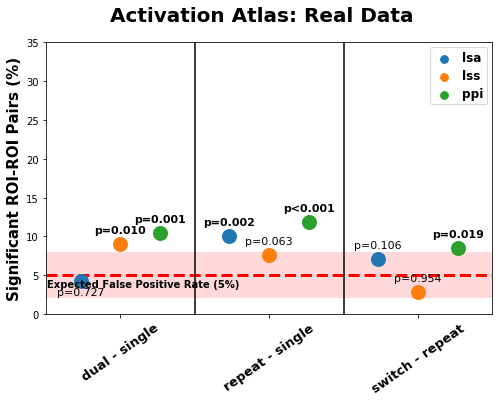

In [40]:
fig, pfd = make_summary_plots(contrast_order, method_order, result_df, "activation", "real", 210)
save_eps(fig, 'outputs/data-real_atlas-activation_participants-filtered_permutation_summary_ppi')

In [41]:
pfd

atlas  data       contrast estimator participants  observed_value  \
0   activation  real    dualxsingle       ppi     filtered              22   
1   activation  real    dualxsingle       lss     filtered              19   
2   activation  real    dualxsingle       lsa     filtered               9   
6   activation  real  repeatxsingle       ppi     filtered              25   
7   activation  real  repeatxsingle       lss     filtered              16   
8   activation  real  repeatxsingle       lsa     filtered              21   
12  activation  real  switchxrepeat       ppi     filtered              18   
13  activation  real  switchxrepeat       lss     filtered               6   
14  activation  real  switchxrepeat       lsa     filtered              15   

    binom_p_value    corr_t        corr_p  pos_res  neg_res  \
0        0.000927  5.044984  9.901024e-07        1       21   
1        0.009621  5.044984  9.901024e-07        6       13   
2        0.727066  5.044984  9.901024e-07        0        9   
6        0.000059  4.842234  2.510241e-06        1       24   
7        0.063322  4.842234  2.510241e-06        1       15   
8        0.002121  4.842234  2.510241e-06        0       21   
12       0.019006  3.317922  1.071301e-03       16        2   
13       0.953639  3.317922  1.071301e-03        5        1   
14       0.106486  3.317922  1.071301e-03       13        2   

    observed_value_percent  
0                10.476190  
1                 9.047619  
2                 4.285714  
6                11.904762  
7                 7.619048  
8                10.000000  
12                8.571429  
13                2.857143  
14                7.142857

### Activation Atlas Null Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


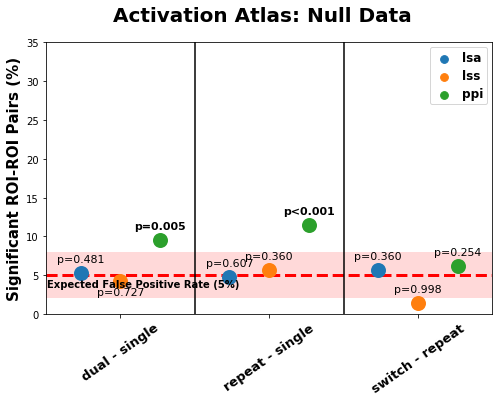

In [42]:
fig, pfd = make_summary_plots(contrast_order, method_order, result_df, "activation", "null", 210)
save_eps(fig, 'outputs/data-null_atlas-activation_participants-filtered_permutation_summary_ppi')

In [43]:
pfd

atlas  data       contrast estimator participants  observed_value  \
3   activation  null    dualxsingle       ppi     filtered              20   
4   activation  null    dualxsingle       lss     filtered               9   
5   activation  null    dualxsingle       lsa     filtered              11   
9   activation  null  repeatxsingle       ppi     filtered              24   
10  activation  null  repeatxsingle       lss     filtered              12   
11  activation  null  repeatxsingle       lsa     filtered              10   
15  activation  null  switchxrepeat       ppi     filtered              13   
16  activation  null  switchxrepeat       lss     filtered               3   
17  activation  null  switchxrepeat       lsa     filtered              12   

    binom_p_value    corr_t        corr_p  pos_res  neg_res  \
3        0.004630  5.166868  5.586028e-07       10       10   
4        0.727066  5.166868  5.586028e-07        3        6   
5        0.480841  5.166868  5.586028e-07        3        8   
9        0.000154  5.463554  1.332492e-07        8       16   
10       0.359715  5.463554  1.332492e-07        5        7   
11       0.607417  5.463554  1.332492e-07        3        7   
15       0.253996  2.459837  1.471981e-02       11        2   
16       0.998471  2.459837  1.471981e-02        2        1   
17       0.359715  2.459837  1.471981e-02        7        5   

    observed_value_percent  
3                 9.523810  
4                 4.285714  
5                 5.238095  
9                11.428571  
10                5.714286  
11                4.761905  
15                6.190476  
16                1.428571  
17                5.714286

### Schaeferbest Atlas Real Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


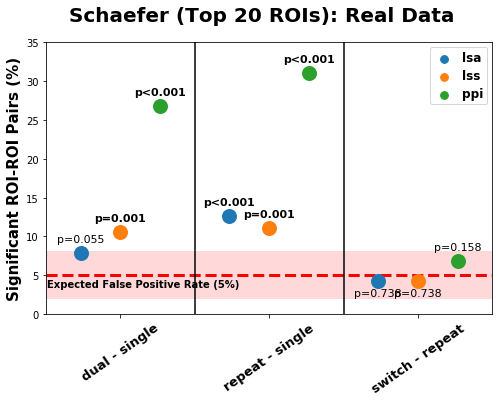

In [44]:
fig, pfd = make_summary_plots(contrast_order, method_order, result_df, "schaeferbest", "real", 190)
save_eps(fig, 'outputs/data-real_atlas-schaeferbest_participants-filtered_permutation_summary_ppi')

In [45]:
pfd

atlas  data       contrast estimator participants  observed_value  \
18  schaeferbest  real    dualxsingle       ppi     filtered              51   
19  schaeferbest  real    dualxsingle       lss     filtered              20   
20  schaeferbest  real    dualxsingle       lsa     filtered              15   
30  schaeferbest  real  repeatxsingle       ppi     filtered              59   
31  schaeferbest  real  repeatxsingle       lss     filtered              21   
32  schaeferbest  real  repeatxsingle       lsa     filtered              24   
42  schaeferbest  real  switchxrepeat       ppi     filtered              13   
43  schaeferbest  real  switchxrepeat       lss     filtered               8   
44  schaeferbest  real  switchxrepeat       lsa     filtered               8   

    binom_p_value    corr_t    corr_p  pos_res  neg_res  \
18   2.684518e-23  4.695134  0.000005        4       47   
19   1.452794e-03  4.695134  0.000005        7       13   
20   5.520896e-02  4.695134  0.000005        0       15   
30   1.948790e-30  4.727675  0.000004        5       54   
31   5.989147e-04  4.727675  0.000004       10       11   
32   3.146980e-05  4.727675  0.000004        0       24   
42   1.581039e-01 -0.613044  0.540592        9        4   
43   7.379910e-01 -0.613044  0.540592        7        1   
44   7.379910e-01 -0.613044  0.540592        8        0   

    observed_value_percent  
18               26.842105  
19               10.526316  
20                7.894737  
30               31.052632  
31               11.052632  
32               12.631579  
42                6.842105  
43                4.210526  
44                4.210526

### Schaeferbest Atlas Null Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


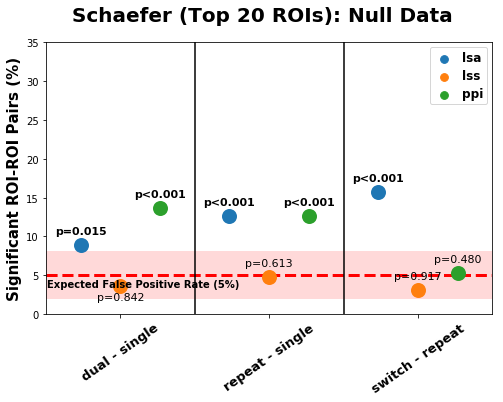

In [46]:
fig, pfd = make_summary_plots(contrast_order, method_order, result_df, "schaeferbest", "null", 190)
save_eps(fig, 'outputs/data-null_atlas-schaeferbest_participants-filtered_permutation_summary_ppi')

In [47]:
pfd

atlas  data       contrast estimator participants  observed_value  \
24  schaeferbest  null    dualxsingle       ppi     filtered              26   
25  schaeferbest  null    dualxsingle       lss     filtered               7   
26  schaeferbest  null    dualxsingle       lsa     filtered              17   
36  schaeferbest  null  repeatxsingle       ppi     filtered              24   
37  schaeferbest  null  repeatxsingle       lss     filtered               9   
38  schaeferbest  null  repeatxsingle       lsa     filtered              24   
48  schaeferbest  null  switchxrepeat       ppi     filtered              10   
49  schaeferbest  null  switchxrepeat       lss     filtered               6   
50  schaeferbest  null  switchxrepeat       lsa     filtered              30   

    binom_p_value    corr_t        corr_p  pos_res  neg_res  \
24   3.523359e-06  4.674898  5.617094e-06       11       15   
25   8.418625e-01  4.674898  5.617094e-06        7        0   
26   1.520590e-02  4.674898  5.617094e-06        5       12   
36   3.146980e-05  6.272384  2.407574e-09       13       11   
37   6.129351e-01  6.272384  2.407574e-09        7        2   
38   3.146980e-05  6.272384  2.407574e-09        5       19   
48   4.798347e-01  1.864937  6.375693e-02        8        2   
49   9.169436e-01  1.864937  6.375693e-02        5        1   
50   2.686470e-08  1.864937  6.375693e-02       24        6   

    observed_value_percent  
24               13.684211  
25                3.684211  
26                8.947368  
36               12.631579  
37                4.736842  
38               12.631579  
48                5.263158  
49                3.157895  
50               15.789474

### Schaefer Atlas Real Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


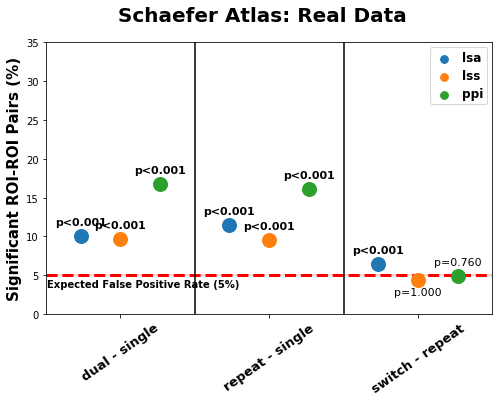

In [48]:
fig, pfd = make_summary_plots(contrast_order, method_order, result_df, "schaefer", "real", 79800)
save_eps(fig, 'outputs/data-real_atlas-schaefer_participants-filtered_permutation_summary_ppi')

In [49]:
pfd

atlas  data       contrast estimator participants  observed_value  \
21  schaefer  real    dualxsingle       ppi     filtered           13362   
22  schaefer  real    dualxsingle       lss     filtered            7723   
23  schaefer  real    dualxsingle       lsa     filtered            8069   
33  schaefer  real  repeatxsingle       ppi     filtered           12895   
34  schaefer  real  repeatxsingle       lss     filtered            7631   
35  schaefer  real  repeatxsingle       lsa     filtered            9145   
45  schaefer  real  switchxrepeat       ppi     filtered            3947   
46  schaefer  real  switchxrepeat       lss     filtered            3462   
47  schaefer  real  switchxrepeat       lsa     filtered            5153   

    binom_p_value      corr_t  corr_p  pos_res  neg_res  \
21   0.000000e+00   95.191398     0.0     2341    11021   
22   0.000000e+00   95.191398     0.0     1227     6496   
23   0.000000e+00   95.191398     0.0     1016     7053   
33   0.000000e+00  108.668367     0.0     2025    10870   
34   0.000000e+00  108.668367     0.0     1366     6265   
35   0.000000e+00  108.668367     0.0      765     8380   
45   7.596967e-01   57.127241     0.0     3075      872   
46   1.000000e+00   57.127241     0.0     1499     1963   
47   1.380611e-73   57.127241     0.0     4372      781   

    observed_value_percent  
21               16.744361  
22                9.677945  
23               10.111529  
33               16.159148  
34                9.562657  
35               11.459900  
45                4.946115  
46                4.338346  
47                6.457393

### SchaeferAtlas Null Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


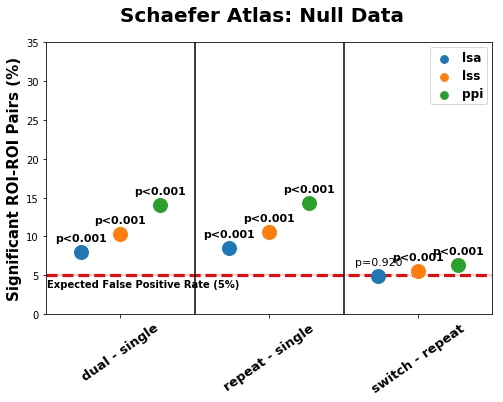

In [50]:
fig, pfd = make_summary_plots(contrast_order, method_order, result_df, "schaefer", "null", 79800)
save_eps(fig, 'outputs/data-null_atlas-schaefer_participants-filtered_permutation_summary_ppi')

In [51]:
pfd

atlas  data       contrast estimator participants  observed_value  \
27  schaefer  null    dualxsingle       ppi     filtered           11184   
28  schaefer  null    dualxsingle       lss     filtered            8213   
29  schaefer  null    dualxsingle       lsa     filtered            6384   
39  schaefer  null  repeatxsingle       ppi     filtered           11375   
40  schaefer  null  repeatxsingle       lss     filtered            8461   
41  schaefer  null  repeatxsingle       lsa     filtered            6762   
51  schaefer  null  switchxrepeat       ppi     filtered            5037   
52  schaefer  null  switchxrepeat       lss     filtered            4443   
53  schaefer  null  switchxrepeat       lsa     filtered            3904   

    binom_p_value      corr_t  corr_p  pos_res  neg_res  \
27   0.000000e+00   98.845152     0.0     4596     6588   
28   0.000000e+00   98.845152     0.0     1567     6646   
29  1.339624e-282   98.845152     0.0     1053     5331   
39   0.000000e+00  108.629920     0.0     4035     7340   
40   0.000000e+00  108.629920     0.0     1682     6779   
41   0.000000e+00  108.629920     0.0     1088     5674   
51   1.716500e-60   38.517940     0.0     3874     1163   
52   2.479320e-13   38.517940     0.0     3372     1071   
53   9.203426e-01   38.517940     0.0     2974      930   

    observed_value_percent  
27               14.015038  
28               10.291980  
29                8.000000  
39               14.254386  
40               10.602757  
41                8.473684  
51                6.312030  
52                5.567669  
53                4.892231

## analyze correlation results

In [52]:
correlation_df = pd.DataFrame.from_dict(correlation_collector)
correlation_df.to_csv('./outputs/observed_correlation_results.tsv', sep='\t')
correlation_df

atlas  data       contrast participants   lssxppi   lsaxppi  \
0     activation  real    dualxsingle     filtered  0.566391  0.220175   
1     activation  null    dualxsingle     filtered  0.700475  0.422975   
2     activation  real  repeatxsingle     filtered  0.561675  0.229350   
3     activation  null  repeatxsingle     filtered  0.693176  0.397595   
4     activation  real  switchxrepeat     filtered  0.470840  0.226719   
5     activation  null  switchxrepeat     filtered  0.439740  0.250356   
6   schaeferbest  real    dualxsingle     filtered  0.590885  0.314765   
7       schaefer  real    dualxsingle     filtered  0.578125  0.266044   
8   schaeferbest  null    dualxsingle     filtered  0.604566  0.270417   
9       schaefer  null    dualxsingle     filtered  0.686850  0.420366   
10  schaeferbest  real  repeatxsingle     filtered  0.672884  0.420643   
11      schaefer  real  repeatxsingle     filtered  0.618795  0.270087   
12  schaeferbest  null  repeatxsingle     filtered  0.692019  0.237250   
13      schaefer  null  repeatxsingle     filtered  0.703669  0.416483   
14  schaeferbest  real  switchxrepeat     filtered  0.172562  0.225835   
15      schaefer  real  switchxrepeat     filtered  0.390205  0.168375   
16  schaeferbest  null  switchxrepeat     filtered  0.351983  0.190223   
17      schaefer  null  switchxrepeat     filtered  0.413874  0.265505   

     lsaxlss      corr_t        corr_p  
0   0.308514    5.044984  9.901024e-07  
1   0.433257    5.166868  5.586028e-07  
2   0.312607    4.842234  2.510241e-06  
3   0.440006    5.463554  1.332492e-07  
4   0.293432    3.317922  1.071301e-03  
5   0.244422    2.459837  1.471981e-02  
6   0.514789    4.695134  5.141918e-06  
7   0.376857   95.191398  0.000000e+00  
8   0.278159    4.674898  5.617094e-06  
9   0.468152   98.845152  0.000000e+00  
10  0.527124    4.727675  4.458067e-06  
11  0.362203  108.668367  0.000000e+00  
12  0.138246    6.272384  2.407574e-09  
13  0.469218  108.629920  0.000000e+00  
14  0.251641   -0.613044  5.405918e-01  
15  0.300093   57.127241  0.000000e+00  
16  0.201147    1.864937  6.375693e-02  
17  0.285002   38.517940  0.000000e+00

In [53]:
# mean lssxppi correlation
correlation_df.loc[:, 'lssxppi'].mean()

0.5504840735822806

In [54]:
# mean lsaxppi correlation
correlation_df.loc[:, 'lsaxppi'].mean()

0.2896201875422084

In [55]:
# mean lsaxlss correlation
correlation_df.loc[:, 'lsaxlss'].mean()

0.34471489306416153

In [56]:
# mean difference between lssxppi and lsaxppi
# (lss is more correlated with ppi than lsa)
correlation_df.loc[:, 'lssxppi'].mean() - correlation_df.loc[:, 'lsaxppi'].mean()

0.26086388604007216

## Analyze distribution of positive/negatives

In [57]:
result_df['positive_ratio'] = result_df['pos_res'] / (result_df['pos_res'] + result_df['neg_res'])
result_df

atlas  data       contrast estimator participants  observed_value  \
0     activation  real    dualxsingle       ppi     filtered              22   
1     activation  real    dualxsingle       lss     filtered              19   
2     activation  real    dualxsingle       lsa     filtered               9   
3     activation  null    dualxsingle       ppi     filtered              20   
4     activation  null    dualxsingle       lss     filtered               9   
5     activation  null    dualxsingle       lsa     filtered              11   
6     activation  real  repeatxsingle       ppi     filtered              25   
7     activation  real  repeatxsingle       lss     filtered              16   
8     activation  real  repeatxsingle       lsa     filtered              21   
9     activation  null  repeatxsingle       ppi     filtered              24   
10    activation  null  repeatxsingle       lss     filtered              12   
11    activation  null  repeatxsingle       lsa     filtered              10   
12    activation  real  switchxrepeat       ppi     filtered              18   
13    activation  real  switchxrepeat       lss     filtered               6   
14    activation  real  switchxrepeat       lsa     filtered              15   
15    activation  null  switchxrepeat       ppi     filtered              13   
16    activation  null  switchxrepeat       lss     filtered               3   
17    activation  null  switchxrepeat       lsa     filtered              12   
18  schaeferbest  real    dualxsingle       ppi     filtered              51   
19  schaeferbest  real    dualxsingle       lss     filtered              20   
20  schaeferbest  real    dualxsingle       lsa     filtered              15   
21      schaefer  real    dualxsingle       ppi     filtered           13362   
22      schaefer  real    dualxsingle       lss     filtered            7723   
23      schaefer  real    dualxsingle       lsa     filtered            8069   
24  schaeferbest  null    dualxsingle       ppi     filtered              26   
25  schaeferbest  null    dualxsingle       lss     filtered               7   
26  schaeferbest  null    dualxsingle       lsa     filtered              17   
27      schaefer  null    dualxsingle       ppi     filtered           11184   
28      schaefer  null    dualxsingle       lss     filtered            8213   
29      schaefer  null    dualxsingle       lsa     filtered            6384   
30  schaeferbest  real  repeatxsingle       ppi     filtered              59   
31  schaeferbest  real  repeatxsingle       lss     filtered              21   
32  schaeferbest  real  repeatxsingle       lsa     filtered              24   
33      schaefer  real  repeatxsingle       ppi     filtered           12895   
34      schaefer  real  repeatxsingle       lss     filtered            7631   
35      schaefer  real  repeatxsingle       lsa     filtered            9145   
36  schaeferbest  null  repeatxsingle       ppi     filtered              24   
37  schaeferbest  null  repeatxsingle       lss     filtered               9   
38  schaeferbest  null  repeatxsingle       lsa     filtered              24   
39      schaefer  null  repeatxsingle       ppi     filtered           11375   
40      schaefer  null  repeatxsingle       lss     filtered            8461   
41      schaefer  null  repeatxsingle       lsa     filtered            6762   
42  schaeferbest  real  switchxrepeat       ppi     filtered              13   
43  schaeferbest  real  switchxrepeat       lss     filtered               8   
44  schaeferbest  real  switchxrepeat       lsa     filtered               8   
45      schaefer  real  switchxrepeat       ppi     filtered            3947   
46      schaefer  real  switchxrepeat       lss     filtered            3462   
47      schaefer  real  switchxrepeat       lsa     filtered            5153   
48  schaeferbest  null  switchxrepeat       ppi     filtered              10   
49  schaefe

In [58]:
result_df['bias_ratio'] = (result_df['pos_res'] - result_df['neg_res']).abs() / (result_df['pos_res'] + result_df['neg_res'])
result_df

atlas  data       contrast estimator participants  observed_value  \
0     activation  real    dualxsingle       ppi     filtered              22   
1     activation  real    dualxsingle       lss     filtered              19   
2     activation  real    dualxsingle       lsa     filtered               9   
3     activation  null    dualxsingle       ppi     filtered              20   
4     activation  null    dualxsingle       lss     filtered               9   
5     activation  null    dualxsingle       lsa     filtered              11   
6     activation  real  repeatxsingle       ppi     filtered              25   
7     activation  real  repeatxsingle       lss     filtered              16   
8     activation  real  repeatxsingle       lsa     filtered              21   
9     activation  null  repeatxsingle       ppi     filtered              24   
10    activation  null  repeatxsingle       lss     filtered              12   
11    activation  null  repeatxsingle       lsa     filtered              10   
12    activation  real  switchxrepeat       ppi     filtered              18   
13    activation  real  switchxrepeat       lss     filtered               6   
14    activation  real  switchxrepeat       lsa     filtered              15   
15    activation  null  switchxrepeat       ppi     filtered              13   
16    activation  null  switchxrepeat       lss     filtered               3   
17    activation  null  switchxrepeat       lsa     filtered              12   
18  schaeferbest  real    dualxsingle       ppi     filtered              51   
19  schaeferbest  real    dualxsingle       lss     filtered              20   
20  schaeferbest  real    dualxsingle       lsa     filtered              15   
21      schaefer  real    dualxsingle       ppi     filtered           13362   
22      schaefer  real    dualxsingle       lss     filtered            7723   
23      schaefer  real    dualxsingle       lsa     filtered            8069   
24  schaeferbest  null    dualxsingle       ppi     filtered              26   
25  schaeferbest  null    dualxsingle       lss     filtered               7   
26  schaeferbest  null    dualxsingle       lsa     filtered              17   
27      schaefer  null    dualxsingle       ppi     filtered           11184   
28      schaefer  null    dualxsingle       lss     filtered            8213   
29      schaefer  null    dualxsingle       lsa     filtered            6384   
30  schaeferbest  real  repeatxsingle       ppi     filtered              59   
31  schaeferbest  real  repeatxsingle       lss     filtered              21   
32  schaeferbest  real  repeatxsingle       lsa     filtered              24   
33      schaefer  real  repeatxsingle       ppi     filtered           12895   
34      schaefer  real  repeatxsingle       lss     filtered            7631   
35      schaefer  real  repeatxsingle       lsa     filtered            9145   
36  schaeferbest  null  repeatxsingle       ppi     filtered              24   
37  schaeferbest  null  repeatxsingle       lss     filtered               9   
38  schaeferbest  null  repeatxsingle       lsa     filtered              24   
39      schaefer  null  repeatxsingle       ppi     filtered           11375   
40      schaefer  null  repeatxsingle       lss     filtered            8461   
41      schaefer  null  repeatxsingle       lsa     filtered            6762   
42  schaeferbest  real  switchxrepeat       ppi     filtered              13   
43  schaeferbest  real  switchxrepeat       lss     filtered               8   
44  schaeferbest  real  switchxrepeat       lsa     filtered               8   
45      schaefer  real  switchxrepeat       ppi     filtered            3947   
46      schaefer  real  switchxrepeat       lss     filtered            3462   
47      schaefer  real  switchxrepeat       lsa     filtered            5153   
48  schaeferbest  null  switchxrepeat       ppi     filtered              10   
49  schaefe

In [59]:
# identify if there is a greater number of negative or positive results in the real data
result_df.query("data == 'real'").groupby("estimator")['bias_ratio'].mean()

estimator
lsa    0.890120
lss    0.496219
ppi    0.728756
Name: bias_ratio, dtype: float64

In [60]:
# identify if there is a greater number of negative or positive results in the null data 
result_df.query("data == 'null'").groupby("estimator")['bias_ratio'].mean()

estimator
lsa    0.498688
lss    0.532697
ppi    0.318855
Name: bias_ratio, dtype: float64

In [61]:
# identify if there is a positive bias in the real data
result_df.query("data == 'real'").groupby("contrast")['positive_ratio'].mean()

contrast
dualxsingle      0.138852
repeatxsingle    0.120348
switchxrepeat    0.801855
Name: positive_ratio, dtype: float64

In [62]:
# identify if there is a positive bias in the null data
result_df.query("data == 'null'").groupby("contrast")['positive_ratio'].mean()

contrast
dualxsingle      0.398882
repeatxsingle    0.365800
switchxrepeat    0.757703
Name: positive_ratio, dtype: float64

In [63]:
# identify if there is a positive bias in the real data
result_df.query("data == 'real'").groupby(["contrast", "estimator"])['positive_ratio'].mean()

contrast       estimator
dualxsingle    lsa          0.041971
               lss          0.274889
               ppi          0.099695
repeatxsingle  lsa          0.027884
               lss          0.239232
               ppi          0.093928
switchxrepeat  lsa          0.905035
               lss          0.713773
               ppi          0.786756
Name: positive_ratio, dtype: float64

In [64]:
# identify if there is a positive bias in the null data
result_df.query("data == 'null'").groupby(["contrast", "estimator"])['positive_ratio'].mean()

contrast       estimator
dualxsingle    lsa          0.243930
               lss          0.508043
               ppi          0.444674
repeatxsingle  lsa          0.223077
               lss          0.464413
               ppi          0.409908
switchxrepeat  lsa          0.715039
               lss          0.752982
               ppi          0.805087
Name: positive_ratio, dtype: float64

In [65]:
all_estimates = pd.concat(dataframe_estimates)
all_estimates['atlas'].unique()

array(['activation', 'schaeferbest', 'schaefer'], dtype=object)

In [70]:
all_estimates_activation = all_estimates.query("atlas == 'schaeferbest'")

In [137]:
def correlation_plot(estimates_df, atlas, x_bins=None):
    
    g = sns.lmplot(
            x='ppi', y='estimates', hue='estimators',
            hue_order=['lsa', 'lss'], row='contrast',
            col='data',
            x_bins=x_bins,
            data=estimates_df.query("atlas == '{}'".format(atlas)),
            truncate=True,
            line_kws={"linewidth": 4},
            scatter_kws={"alpha": 0.4},
            sharex=False,
            ci=None,
            legend_out=False,
    )

    for ax in g.axes.flatten():
        title = ax.get_title()
        contrast, data = [cond.split(" = ")[1] for cond in title.split(' | ')]
        new_title = contrast.replace('x', ' - ').title() + " (" + data.title() + ")"
        ax.set_title(new_title, size=15, weight="heavy")
    g.set_xlabels("PPI Estimates", size=15, weight="heavy")
    g.set_ylabels("")
    g.axes[1, 0].set_ylabel("LSA/LSS Estimates", size=15, weight="heavy")

    legend_ax = g.axes[0, 0]

    legend_ax.legend_.set_title("")
    legend_ax.legend_.texts[0].set(size=12, weight='bold')
    
    return g

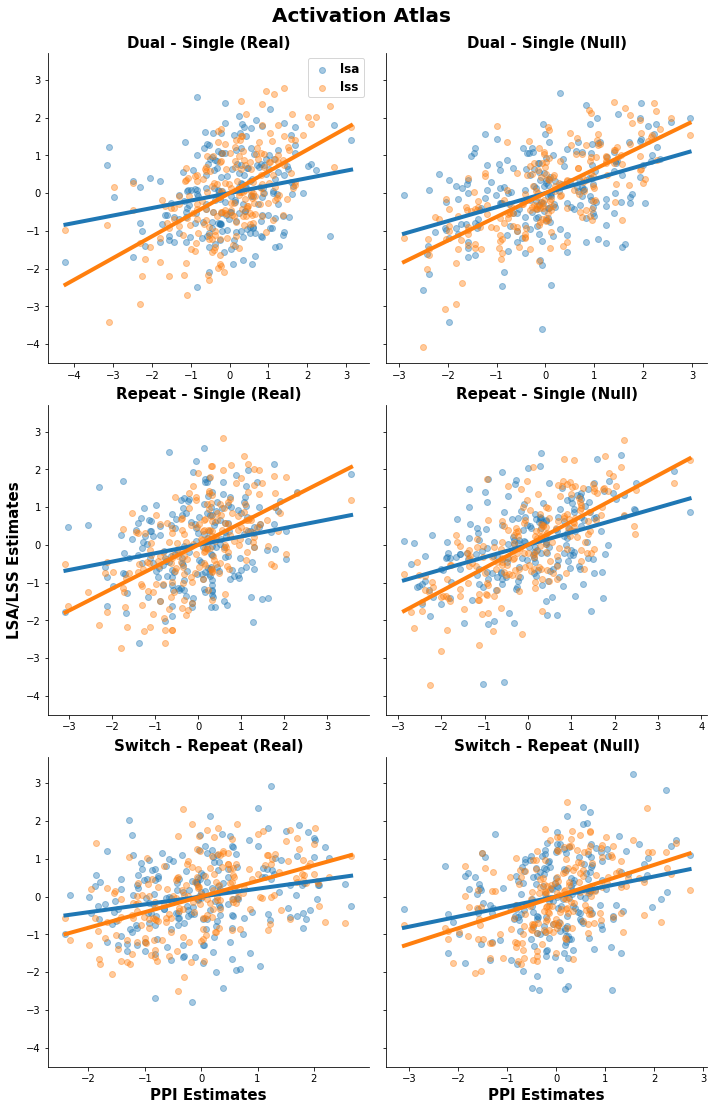

In [132]:
g = correlation_plot(all_estimates, "activation")
g.fig.suptitle("Activation Atlas", size=20, weight="heavy", y=1.02)
save_eps(g.fig, "outputs/atlas-activation_estimate_correlations")

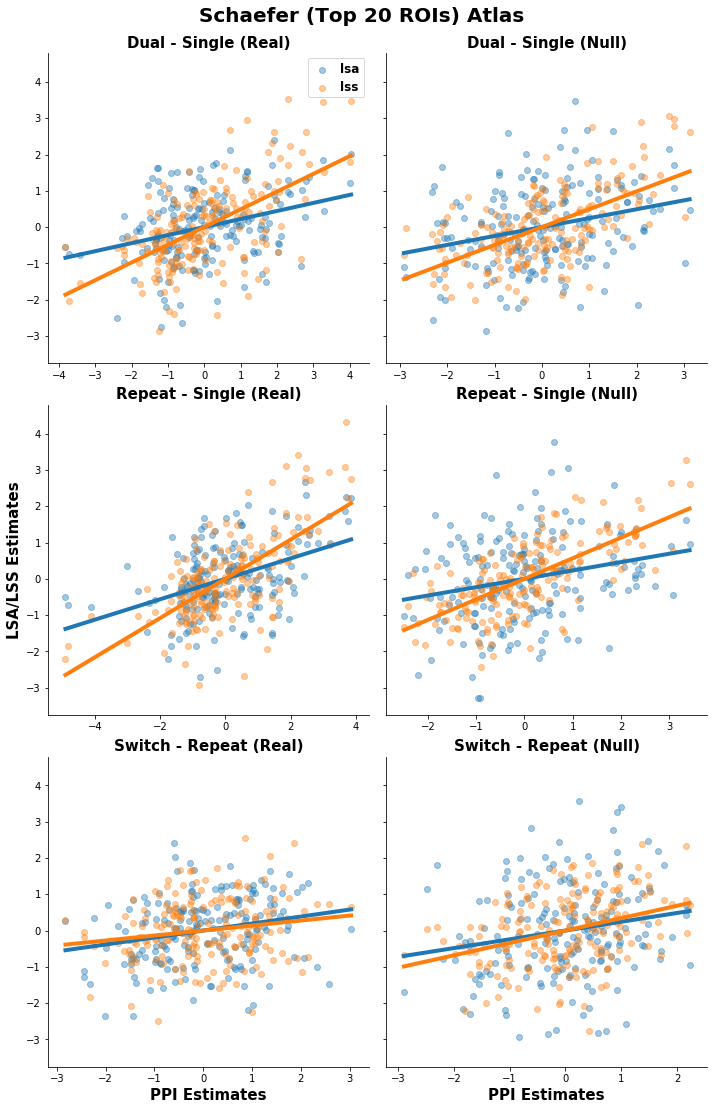

In [133]:
g = correlation_plot(all_estimates, "schaeferbest")
g.fig.suptitle("Schaefer (Top 20 ROIs) Atlas", size=20, weight="heavy", y=1.02)
save_eps(g.fig, "outputs/atlas-schaeferbest_estimate_correlations")

In [ ]:
g = correlation_plot(all_estimates, "schaefer", x_bins=3000)
g.fig.suptitle("Schaefer Atlas", size=20, weight="heavy", y=1.02)
save_eps(g.fig, "outputs/atlas-schaefer_estimate_correlations")